## implementing LDA with gensim
1) import dataset
2) preprocess text
3) create gensim dictionary and corpus
4) build the topic model
5) analyze

In [ ]:
# Only run this once
import nltk
nltk.download('all')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser as parser
import re
import os
import string
import logging
from pprint import pprint
from collections import defaultdict # for pos tag -> wordnet tag

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import gensim
import pyLDAvis.gensim
from gensim.models import Phrases # For adding n-grams
from gensim import corpora, models, similarities 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# Perform topic modelling with the help of nltk and gensim 
#
class TopicModeler:
    # Initialize an instance of the TopicModeler class
    # params:
    #   corpus<numpy.ndarray([string])>: A numpy array of strings, representing documents in a corpus
    #   disp_interval<integer>: Display progess after each interval
    #
    def __init__(self, corpus, disp_interval=1000):
        self.corpus = np.copy(corpus)
        self.dictionary = None
        self.model = None
        self.disp_interval = disp_interval
        self.N = np.shape(self.corpus)[0]
        logging.info('Initialized a TopicModeler with corpus size N=' + str(self.N))
        return
        
        
    # Split the documents in the corpus into lists of raw tokens
    # params:
    #   disp_interval<integer>: Display progess after each interval
    #
    def tokenize(self, disp_interval=None):
        if disp_interval == None:
            disp_interval = self.disp_interval
            
        # Convert each document in the corpus into a list of tokens 
        for document in range(self.N):
            if (document % disp_interval == 0):
                logging.info('Performing tokenization: [' + str(document) + '/' + str(self.N) + ']')
            self.corpus[document] = word_tokenize(self.corpus[document])
        return
    
    
    # Perform morphological normalization on the corpus as a list of raw tokens
    # params:
    #   norm<'lemma'|'stem'>: The form of morphological normalization to use
    #   disp_interval<integer>: Display progess after each interval
    #
    def normalize(self, norm='stem', disp_interval=None):
        logging.info('Performing normalization.')
        logging.debug('norm=' + str(norm))
        if disp_interval == None:
            disp_interval = self.disp_interval
        
        if (norm == 'lemma'):
            lemmatizer = WordNetLemmatizer()
            
            # Maps nltk pos tags into wordnet pos tags
            tag_map = defaultdict(lambda : wordnet.NOUN)
            tag_map['J'] = wordnet.ADJ
            tag_map['V'] = wordnet.VERB
            tag_map['R'] = wordnet.ADV
            
            for document in range(self.N):
                if (document % disp_interval == 0):
                    logging.info('Performing lemmatization: [' + str(document) + '/' + str(self.N) + ']')
                self.corpus[document] = [lemmatizer.lemmatize(tagged_token[0], tag_map[tagged_token[1][0]])
                            for tagged_token in pos_tag(self.corpus[document])]
        elif (norm == 'stem'):
            stemmer = PorterStemmer()
            
            for document in range(self.N):
                if (document % disp_interval == 0):
                    logging.info('Performing stemming: [' + str(document) + '/' + str(self.N) + ']')
                self.corpus[document] = [stemmer.stem(token) for token in self.corpus[document]]
        else:
            logging.warning('Invalid parameter! Skipping normalization...')
        return
            
        
    # Filter out any tokens that are not within a specified string length
    # params:
    #   min_strlen<integer>: The minimum amount of chars a token can have
    #   max_strlen<integer>: The maximum amount of chars a token can have
    #
    def filter_length(self, min_strlen=1, max_strlen=100):
        logging.info('Filtering out tokens that are out of the length bounds.')
        logging.debug('min_strlen=' + str(min_strlen))
        logging.debug('max_strlen=' + str(max_strlen))
        
        self.corpus = [[token for token in document
                            if len(token) >= min_strlen
                            and len(token) <= max_strlen
                       ] for document in self.corpus]
        return
    
    
    # Filter out any tokens that match a regular expression
    # params:
    #   pattern<raw string>: The regular expresstion to match
    #
    def filter_match(self, pattern):
        logging.info('Filtering out tokens that match the regular expression: ' + str(pattern))
        
        self.corpus = [[token for token in document
                            if re.search(pattern, token)
                       ] for document in self.corpus]
        return
    
    
    # Lowercase all tokens
    #
    def lowercase(self):
        logging.info('Converting all tokens to lowercase.')
        self.corpus = [[token.lower() for token in document] for document in self.corpus]
        return
        
        
    # Add n-grams to the corpus
    # params:
    #   n<integer(2|3)>: The maximum length of the sequence of words to add to the corpus
    #   min_count<integer>: The minimum amount of token occurances needed for an n-gram to be included
    #
    def add_n_grams(self, n=2, min_count=1):
        logging.info('Adding n-grams.')
        logging.debug('n=' + str(n))
        logging.debug('min_count=' + str(min_count))

        logging.info('Adding 2-grams')
        bigram = Phrases(self.corpus, min_count=min_count, delimiter=b' ')
        
        if n == 3:
            logging.info('Adding 3-grams')
            trigram = Phrases(bigram[self.corpus], min_count=1, delimiter=b' ')
            for document in range(self.N):
                self.corpus[document] = [n_gram for n_gram in trigram[bigram[self.corpus[document]]] 
                               if n_gram.count(' ') < n]
        elif n == 2:
            for document in range(self.N):
                self.corpus[document] = [n_gram for n_gram in bigram[self.corpus[document]]
                               if n_gram.count(' ') < n]
        else:
            logging.warning('Invalid parameter! Skipping n-grams...')
        return
    
    
    # Remove stop-words
    # params:
    #   stop<list([string])>: A list containing all stop words to exclude
    #
    def remove_stop_words(self, stop=stopwords.words('english')):
        logging.info('Removing stop-words and n-grams with stop-words.')
        logging.debug('stop_words=' + str(stop))
        
        # Filter out any token containing a stop-word
        self.corpus = [[token for token in document
                            if all(token_part not in stop 
                                   for token_part in token.split())
                       ] for document in self.corpus]
        return
    
    
    # Prepare the corpus for topic modelling
    #
    def preprocess(self):
        logging.info('Pipeline step 2: Preprocessing')
        self.tokenize()
        self.normalize()
        self.filter_length(min_strlen=3)
        self.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
        self.lowercase()
        self.add_n_grams(n=3)
        self.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])
        return
    
    
    # Transform lists of pre-processed tokens into an id: word frequency representation
    # params:
    #   no_below<integer>: The minimum amount of documents a word must appear in to be considered
    #   no_above<float>: The maximum % of documents a word may appear in to be considered
    #
    def generate_dict(self, no_below=100, no_above=0.5):
        logging.info('Generating a dictionary of the corpus.')
        logging.debug('no_below=' + str(no_below))
        logging.debug('no_above=' + str(no_above))
        
        self.dictionary = corpora.Dictionary(self.corpus)

        # Filter out rare and common tokens
        self.dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        return
        
    
    # Transforms lists of pre-processed tokens into a bag of words representation
    #
    def generate_bow(self):
        logging.info('Generating a Bag of Words representation of the corpus.')
        
        # Generate the bag of words
        self.corpus = [self.dictionary.doc2bow(documents) for documents in self.corpus]

        logging.debug('Number of unique tokens: ' + str(len(self.dictionary)))
        logging.debug('Number of documents: ' + str(len(self.corpus)))
        return
    
    
    # Save a frozen, trained topic model to disk
    # params:
    #   path<string>: The path to the save location for the model
    #
    def save_model(self, path='model.gensim'):
        logging.info('Saving the current model at: ' + str(path))
        self.model.save(path)
        return

In [ ]:
# A class for running LDA to do topic modelling
#
class LDA(TopicModeler):
    # Initialize an instance of the LDA class
    # params:
    #   corpus<numpy.ndarray([string])>: A numpy array of strings, representing documents in a corpus
    #   num_topics<integer>: The amount of hidden topics in the corpus
    #   disp_interval<integer>: Display progess after each interval
    #
    def __init__(self, corpus, num_topics=5, disp_interval=1000):
        super().__init__(corpus, disp_interval)
        
        self.num_topics = num_topics
        logging.info('Initialized an LDA with num_topics=' + str(self.num_topics))
        return
    
    
    # A setter for the parameter representing the number of latent semantic topics to model
    # params:
    #   num_topics<integer>: The amount of hidden topics in the corpus
    #
    def set_num_topics(self, num_topics):
        logging.debug('Set num_topics=' + str(self.num_topics))
        self.num_topics = num_topics
        return
    
    
    # Train an LDA model on the corpus
    # params:
    #   batch_size<integer>: The amount of documents to be processed at a time
    #   epochs<integer>: The amount of complete passes through the dataset before completing training
    #   iterations<integer>: Maximum iterations on the corpus before inferring a topic distribution
    #   eval_every<boolean>: Evaluate the log perplexity of the model (2x hit to training time)
    #   eta<string|list>: The dirichlet prior for topic-word distributions
    #   alpha<string|list>: The dirichlet piror for document-topic distributions
    #
    def train(self, batch_size=1000, epochs=10, iterations=400, eval_every=None, eta='auto', alpha='auto'):
        logging.info('Training the LDA model.')
        logging.debug('batch_size=' + str(batch_size))
        logging.debug('epochs=' + str(epochs))
        logging.debug('iterations=' + str(iterations))
        logging.debug('eval_every=' + str(eval_every))
        
        self.model = gensim.models.ldamodel.LdaModel(
            corpus=self.corpus, 
            id2word=self.dictionary, 
            num_topics=self.num_topics, 
            passes=epochs, 
            iterations=iterations, 
            chunksize=batch_size,
            alpha=alpha, eta=eta,
            eval_every=eval_every
        )
        for (i, z) in zip(range(self.num_topics), self.model.print_topics(num_words=self.num_topics)):
            logging.debug('Topic #' + str(i) + ": " + str(z))
        return
    
    
    # Retrieve set of topics for a document from a trained LDA model
    # params:
    #   document<integer>: The index of the document for which topics will be retrieved
    # returns: <type>: TODO
    #
    def get_document_topics(self, document=0):
        return self.model.get_document_topics(self.corpus[document])
    
    
    # Calculate the topic coherence for an LDA model
    # This is the sum of topic coherences of all topics, divided by the number of topics
    # params:
    #   num_topics<integer>: The amount of hidden topics in the corpus
    # returns: <float>: The average topic coherence for this model 
    #
    def get_coherence(self, num_topics=5):
        top_topics = self.model.top_topics(self.corpus)
        avg_topic_coherence = sum([z[1] for z in top_topics]) / self.num_topics
        logging.info('Average topic coherence: ' + str(avg_topic_coherence))
        return avg_topic_coherence
    
    
    # Get the perplexity of an LDA model over the entire corpus
    # returns: <float>: The average topic coherence for this model 
    #
    def get_perplexity(self):
        perplexity = self.model.log_perplexity(self.corpus)
        logging.info('Perplexity: ' + str(perplexity))
        return perplexity
    
    
    # Pretty print the top topics for this model
    #
    def print_topics(self):
        pprint(self.model.top_topics(self.corpus))
        return

    
    # Generate an HTML page to visualize the top topic distrubutions as 2D vectors
    #
    def generate_visual_LDA(self):
        logging.info('Generating an HTML page to display the LDA topic distributions...')
        lda_vis_data = pyLDAvis.gensim.prepare(self.model, self.corpus, self.dictionary)
        pyLDAvis.show(lda_vis_data)
        return
    
    
    # Save a frozen, trained topic model to disk
    # params:
    #   path<string>: The the path to the location where this HTML page should be saved
    #
    def save_visual(self, path='lda-vis-data.html'):
        logging.info('Saving the LDA visualization at: ' + str(path))
        lda_vis_data = pyLDAvis.gensim.prepare(self.model, self.corpus, self.dictionary)
        pyLDAvis.save_html(lda_vis_data, path)
        return

## Optimization of parameters for the LDA model

In [ ]:
# (1) IMPORT DATASET
# Dataset is from https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv
data = pd.read_csv('../data/metadata.csv', low_memory = False)
keep_columns = ['publish_time', 'journal', 'abstract']

# Select the relevant columns and rows from the dataset
new_data = data[keep_columns].dropna(subset=['abstract']).to_numpy()

### Optimization of Preprocessing Steps

In [ ]:
## no_below and no_above
## Within what bounds of frequency should a candidate keyword appear in order to be considered?
repetitions = 5
corpus_size = 10000
num_topics = 5


## The minimum amount of documents a word must appear in to be considered
candidate_no_below = [1, 10, 50, 100]
avg_coherence = []
perplexity = []

for nb in candidate_no_below:
    logging.info('no_below=' + str(nb))
    cur_coherence = 0
    cur_perplexity = 0

    
    # (2) PREPROCESS TEXT
    lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
    lda_model.set_num_topics(num_topics)
    lda_model.tokenize()
    lda_model.normalize()
    lda_model.filter_length(min_strlen=3)
    lda_model.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
    lda_model.lowercase()
    lda_model.add_n_grams(n=3)
    lda_model.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])

    # (3) PROCESS TEXT
    # (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
    lda_model.generate_dict(no_below=nb)
    lda_model.generate_bow()

    for r in range(repetitions):
        # (3.2) BUILD THE TOPIC MODEL
        lda_model.train()
        lda_model.get_document_topics()

        cur_coherence += lda_model.get_coherence()/repetitions
        cur_perplexity += lda_model.get_perplexity()/repetitions

    # (3.3) Log the avg coherence and perplexity
    avg_coherence.append(cur_coherence)
    perplexity.append(cur_perplexity)


# (4) Visualize the results
## Avg. Coherence
plt.clf()
plt.title("Avg. Coherence for LDA w/ Varying no_below")
plt.xlabel("no_below") 
plt.ylabel("Coherence")
plt.plot([str(cand) for cand in candidate_no_below], avg_coherence, color='navy', linewidth=2, label="LDA")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/no_below-coherence.png')
plt.show()

## Perplexity
plt.clf()
plt.title("Perplexity for LDA w/ Varying no_below")
plt.xlabel("no_below") 
plt.ylabel("Perplexity")
plt.plot([str(cand) for cand in candidate_no_below], perplexity, color='firebrick', linewidth=2, label="LDA")
plt.legend()
plt.savefig('../bin/LDA/no_below-perplexity.png')
plt.show()


## The maximum % of documents a word may appear in to be considered
candidate_no_above = [.5, .6, .7, .8]
avg_coherence = []
perplexity = []

for na in candidate_no_above:
    logging.info('no_above=' + str(na))
    cur_coherence = 0
    cur_perplexity = 0

        
    # (2) PREPROCESS TEXT
    lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
    lda_model.set_num_topics(num_topics)
    lda_model.tokenize()
    lda_model.normalize()
    lda_model.filter_length(min_strlen=3)
    lda_model.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
    lda_model.lowercase()
    lda_model.add_n_grams(n=3)
    lda_model.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])
    
    # (3) PROCESS TEXT
    # (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
    lda_model.generate_dict(no_above=na)
    lda_model.generate_bow()

    for r in range(repetitions):
        # (3.2) BUILD THE TOPIC MODEL
        lda_model.train()
        lda_model.get_document_topics()

        cur_coherence += lda_model.get_coherence()/repetitions
        cur_perplexity += lda_model.get_perplexity()/repetitions

    # (3.3) Log the avg coherence and perplexity
    avg_coherence.append(cur_coherence)
    perplexity.append(cur_perplexity)


# (4) Visualize the results
## Avg. Coherence
plt.clf()
plt.title("Avg. Coherence for LDA w/ Varying no_above")
plt.xlabel("no_above") 
plt.ylabel("Coherence")
plt.plot([str(cand) for cand in candidate_no_above], avg_coherence, color='navy', linewidth=2, label="LDA")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/no_above-coherence.png')
plt.show()

## Perplexity
plt.clf()
plt.title("Perplexity for LDA w/ Varying no_above")
plt.xlabel("no_above") 
plt.ylabel("Perplexity")
plt.plot([str(cand) for cand in candidate_no_above], perplexity, color='firebrick', linewidth=2, label="LDA")
plt.legend()
plt.savefig('../bin/LDA/no_above-perplexity.png')
plt.show()



In [ ]:
## Stemming or Lemmatization? Or no morphological normalization?
## Stemming - chop off suffixes; lemmatization - get the dictionary form of the word
repetitions = 5

corpus_size = 10000
num_topics = 5

normalization = ['none', 'stem', 'lemma']
avg_coherence = []
perplexity = []
        
        
# Baseline - no morphological normalization   
logging.info('norm=None')
cur_coherence = 0
cur_perplexity = 0

# (2) PREPROCESS TEXT
lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
lda_model.set_num_topics(num_topics)
lda_model.tokenize()
#lda_model.normalize()
lda_model.filter_length(min_strlen=3)
lda_model.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
lda_model.lowercase()
lda_model.add_n_grams(n=3)
lda_model.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])

# (3) PROCESS TEXT
# (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
lda_model.generate_dict()
lda_model.generate_bow()


for r in range(repetitions):
    # (3.2) BUILD THE TOPIC MODEL
    lda_model.train()
    lda_model.get_document_topics()

    cur_coherence += lda_model.get_coherence()/repetitions
    cur_perplexity += lda_model.get_perplexity()/repetitions

# (3.3) Log the avg coherence and perplexity
avg_coherence.append(cur_coherence)
perplexity.append(cur_perplexity)
    
    
# Stemming
logging.info('norm=stem')
cur_coherence = 0
cur_perplexity = 0

# (2) PREPROCESS TEXT
lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
lda_model.set_num_topics(num_topics)
lda_model.tokenize()
lda_model.normalize(norm='stem')
lda_model.filter_length(min_strlen=3)
lda_model.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
lda_model.lowercase()
lda_model.add_n_grams(n=3)
lda_model.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])

# (3) PROCESS TEXT
# (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
lda_model.generate_dict()
lda_model.generate_bow()

for r in range(repetitions):
    # (3.2) BUILD THE TOPIC MODEL
    lda_model.train()
    lda_model.get_document_topics()

    cur_coherence += lda_model.get_coherence()/repetitions
    cur_perplexity += lda_model.get_perplexity()/repetitions

# (3.3) Log the avg coherence and perplexity
avg_coherence.append(cur_coherence)
perplexity.append(cur_perplexity)


# Lemmatization
logging.info('norm=lemma')
cur_coherence = 0
cur_perplexity = 0

# (2) PREPROCESS TEXT
lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
lda_model.set_num_topics(num_topics)
lda_model.tokenize()
lda_model.normalize(norm='lemma')
lda_model.filter_length(min_strlen=3)
lda_model.filter_match(pattern=r'\w*?[a-zA-Z]\w*')
lda_model.lowercase()
lda_model.add_n_grams(n=3)
lda_model.remove_stop_words(stop=stopwords.words('english') + ['use', 'also'])

# (3) PROCESS TEXT
# (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
lda_model.generate_dict()
lda_model.generate_bow()

for r in range(repetitions):
    # (3.2) BUILD THE TOPIC MODEL
    lda_model.train()
    lda_model.get_document_topics()

    cur_coherence += lda_model.get_coherence()/repetitions
    cur_perplexity += lda_model.get_perplexity()/repetitions

# (3.3) Log the avg coherence and perplexity
avg_coherence.append(cur_coherence)
perplexity.append(cur_perplexity)


# (4) Visualize the results
## Avg. Coherence
plt.clf()
plt.title("Avg. Coherence for LDA w/ Various Morphological Normalization")
plt.xlabel("Morphological Normalization") 
plt.ylabel("Coherence")
plt.plot(normalization, avg_coherence, color='navy', linewidth=2, label="LDA")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/normalization-coherence.png')
plt.show()

## Perplexity
plt.clf()
plt.title("Perplexity for LDA w/ Various Morphological Normalization")
plt.xlabel("Morphological Normalization") 
plt.ylabel("Perplexity")
plt.plot(normalization, perplexity, color='firebrick', linewidth=2, label="LDA")
plt.legend()
plt.savefig('../bin/LDA/normalization-perplexity.png')
plt.show()

### Optimization of Hyperparameters

In [ ]:
# (2) PREPROCESS TEXT
corpus_size = 10000
lda_model = LDA(corpus=new_data[:corpus_size, -1], disp_interval=1000)
lda_model.preprocess()

# (3) PROCESS TEXT
# (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
lda_model.generate_dict()
lda_model.generate_bow()

In [ ]:
## Optimizing num_topics
repetitions = 5

candidate_num_topics = [5, 10, 15, 20, 25, 30]
avg_coherence = []
perplexity = []

for k in candidate_num_topics:
    logging.info('num_topics=' + str(num_topics))
    cur_coherence = 0
    cur_perplexity = 0
    lda_model.set_num_topics(k)
    
    # Get the average coherence and perplexity over a number of repetitions
    for r in range(repetitions):
        # (3.2) BUILD THE TOPIC MODEL
        lda_model.train()
        lda_model.get_document_topics()
        
        cur_coherence += lda_model.get_coherence()/repetitions
        cur_perplexity += lda_model.get_perplexity()/repetitions
    
    # (3.3) Log the avg coherence and perplexity
    avg_coherence.append(cur_coherence)
    perplexity.append(cur_perplexity)

    
# (4) Visualize the results
## Avg. Coherence
plt.clf()
plt.title("Avg. Coherence for LDA w/ Varying num_topics")
plt.xlabel("num_topics") 
plt.ylabel("Coherence")
plt.plot(candidate_num_topics, avg_coherence, color='navy', linewidth=2, label="LDA")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/num_topics-coherence.png')
plt.show()

## Perplexity
plt.clf()
plt.title("Perplexity for LDA w/ Varying num_topics")
plt.xlabel("num_topics") 
plt.ylabel("Perplexity")
plt.plot(candidate_num_topics, perplexity, color='firebrick', linewidth=2, label="LDA")
plt.legend()
plt.savefig('../bin/LDA/num_topics-perplexity.png')
plt.show()

In [ ]:
## Optimizing eta (the dirichlet prior for topic-word distributions)
# Expectation: smaller eta == more focused topics; larger == more sparse topics
repetitions = 5

num_topics = 5
lda_model.set_num_topics(num_topics)

candidate_etas = [0.01, 0.1, 1, 10, 'auto']
avg_coherence = []
perplexity = []

for eta in candidate_etas:
    logging.info('candidate_etas=' + str(candidate_etas))
    cur_coherence = 0
    cur_perplexity = 0
    
    # Get the average coherence and perplexity over a number of repetitions
    for r in range(repetitions):
        # (3.2) BUILD THE TOPIC MODEL
        lda_model.train(eta=eta)
        lda_model.get_document_topics()
        
        cur_coherence += lda_model.get_coherence()/repetitions
        cur_perplexity += lda_model.get_perplexity()/repetitions
    
    # (3.3) Log the avg coherence and perplexity
    avg_coherence.append(cur_coherence)
    perplexity.append(cur_perplexity)
    
# (4) Visualize the results
## Avg. Coherence
plt.clf()
plt.title("Avg. Coherence for LDA w/ Varying eta")
plt.xlabel("eta") 
plt.ylabel("Coherence")
plt.plot([str(eta) for eta in candidate_etas], avg_coherence, color='navy', linewidth=2, label="LDA")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/eta-coherence.png')
plt.show()

## Perplexity
plt.clf()
plt.title("Perplexity for LDA w/ Varying eta")
plt.xlabel("eta") 
plt.ylabel("Perplexity")
plt.plot([str(eta) for eta in candidate_etas], perplexity, color='firebrick', linewidth=2, label="LDA")
plt.legend()
plt.savefig('../bin/LDA/eta-perplexity.png')
plt.show()

## Performing LDA on various subsets of the data

In [ ]:
## ALL ABSTRACTS
# (1) IMPORT DATASET
# Dataset is from https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv
data = pd.read_csv('../data/metadata.csv', low_memory = False)
keep_columns = ['publish_time', 'journal', 'abstract']

# Select the relevant columns and rows from the dataset
new_data = data[keep_columns].dropna(subset=['abstract']).to_numpy()

# (2) PREPROCESS TEXT
lda_model = LDA(corpus=new_data[:, -1], num_topics=5)
lda_model.preprocess()

# (3) PROCESS TEXT
# (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
lda_model.generate_dict()
lda_model.generate_bow()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')

# (3.2) BUILD THE TOPIC MODEL
lda_model.train()
lda_model.save_model(path='../bin/LDA/all_model.gensim')
lda_model.get_document_topics()
lda_model.get_coherence()
lda_model.get_perplexity()

# (4) ANALYZE THE DATA
lda_model.print_topics()
lda_model.save_visual(path='../bin/LDA/all_lda-vis-data.html')

2020-06-11 21:43:56,497 : INFO : Running LDA on the top 5 out of 14031 journals


[('PLoS One', 1715), ('Journal of virology', 1600), ('bioRxiv', 1337), ('Surgical endoscopy', 887), ('Virology', 869), ('Sci Rep', 766), ('Viruses', 671), ('Arch Virol', 635), ('Emerg Infect Dis', 628), ('The Journal of general virology', 571), ('J Med Virol', 555), ('Vaccine', 425), ('Virol J', 406), ('BMC Infect Dis', 392), ('PLoS Pathog', 355), ('Journal of clinical microbiology', 345), ('BMJ', 344), ('Virus Res', 312), ('Proceedings of the National Academy of Sciences of the United States of America', 302), ('Obesity surgery', 291), ('Nature', 288), ('PloS one', 281), ('Clin Infect Dis', 271), ('Int J Infect Dis', 271), ('J Infect Dis', 270), ('AJNR. American journal of neuroradiology', 265), ('Antiviral Res', 263), ('Journal of neurointerventional surgery', 258), ('Front Immunol', 246), ('J Virol Methods', 239), ('J. med. virol', 238), ('Science', 233), ('Vet Microbiol', 227), ('Front Microbiol', 213), ('Hernia : the journal of hernias and abdominal wall surgery', 210), ('Veterina

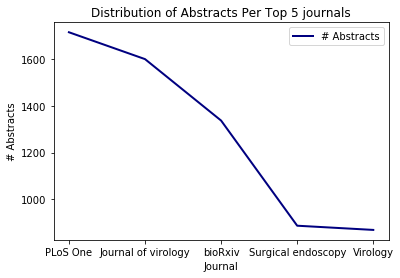

2020-06-11 21:43:56,809 : INFO : Running LDA on journal=PLoS One
2020-06-11 21:43:56,820 : INFO : Initialized a TopicModeler with corpus size N=1715
2020-06-11 21:43:56,820 : INFO : Initialized an LDA with num_topics=5
2020-06-11 21:43:56,820 : INFO : Pipeline step 2: Preprocessing
2020-06-11 21:43:56,821 : INFO : Performing tokenization: [0/1715]
2020-06-11 21:43:58,613 : INFO : Performing tokenization: [1000/1715]
2020-06-11 21:43:59,972 : INFO : Performing normalization.
2020-06-11 21:43:59,972 : INFO : Performing stemming: [0/1715]


KeyboardInterrupt: 

In [17]:
## Top 5 most common journals
# (1) IMPORT DATASET
# Dataset is from https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv
data = pd.read_csv('../data/metadata.csv', low_memory = False)
keep_columns = ['publish_time', 'journal', 'abstract']


# Select the relevant columns and rows from the dataset
new_data = data[keep_columns].dropna(subset=['abstract'])
num_journals = len(new_data.journal.unique())
logging.info("Running LDA on the top 5 out of " + str(num_journals) + " journals")

# Get the 5 most common journals
fdist = nltk.FreqDist(new_data.dropna(subset=['journal']).journal)
print(fdist.most_common())

plt.clf()
plt.title("Distribution of Abstracts Per Top 5 journals")
plt.xlabel("Journal")
plt.ylabel("# Abstracts")

plt.plot([str(j) for (j, count) in fdist.most_common(5)], [count for (j, count) in fdist.most_common(5)], color='navy', linewidth=2, label="# Abstracts")

plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/journals-distribution.png')
plt.show()

for (j, _) in fdist.most_common(5):
    logging.info("Running LDA on journal=" + j)
    cur_data = new_data[new_data['journal'] == j].to_numpy()
    
    # (2) PREPROCESS TEXT
    lda_model = LDA(corpus=cur_data[:, -1], num_topics=5)
    lda_model.preprocess()

    # (3) PROCESS TEXT
    # (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
    lda_model.generate_dict()
    lda_model.generate_bow()

    # (3.2) BUILD THE TOPIC MODEL
    lda_model.train()
    lda_model.save_model(path='../bin/LDA/' + j + '_model.gensim')
    lda_model.get_document_topics()
    lda_model.get_coherence()
    lda_model.get_perplexity()

    # (4) ANALYZE THE DATA
    lda_model.print_topics()
    lda_model.save_visual(path='../bin/LDA/' + j + '_lda-vis-data.html')

2020-06-11 19:30:01,491 : INFO : Running LDA on the top 5 out of 62 years


[(1952, 1), (1955, 2), (1956, 1), (1957, 1), (1962, 1), (1963, 1), (1964, 1), (1965, 1), (1967, 3), (1968, 1), (1969, 5), (1970, 13), (1971, 11), (1972, 18), (1973, 19), (1974, 17), (1975, 33), (1976, 38), (1977, 42), (1978, 55), (1979, 58), (1980, 73), (1981, 101), (1982, 91), (1983, 89), (1984, 115), (1985, 115), (1986, 144), (1987, 156), (1988, 153), (1989, 186), (1990, 226), (1991, 221), (1992, 246), (1993, 237), (1994, 202), (1995, 258), (1996, 223), (1997, 263), (1998, 313), (1999, 307), (2000, 362), (2001, 359), (2002, 586), (2003, 1156), (2004, 1873), (2005, 2106), (2006, 2107), (2007, 2283), (2008, 2836), (2009, 2967), (2010, 3379), (2011, 3864), (2012, 4268), (2013, 4874), (2014, 5705), (2015, 6037), (2016, 6298), (2017, 6393), (2018, 6216), (2019, 6570), (2020, 32742)]


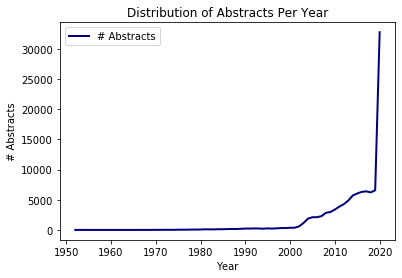

2020-06-11 19:30:02,747 : INFO : Running LDA on year=2010
2020-06-11 19:30:02,768 : INFO : Initialized a TopicModeler with corpus size N=3379
2020-06-11 19:30:02,771 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:30:02,775 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:30:02,777 : INFO : Performing tokenization: [0/3379]
2020-06-11 19:30:10,528 : INFO : Performing tokenization: [1000/3379]
2020-06-11 19:30:19,120 : INFO : Performing tokenization: [2000/3379]
2020-06-11 19:30:26,753 : INFO : Performing tokenization: [3000/3379]
2020-06-11 19:30:29,950 : INFO : Performing normalization.
2020-06-11 19:30:29,953 : INFO : Performing stemming: [0/3379]
2020-06-11 19:30:48,696 : INFO : Performing stemming: [1000/3379]
2020-06-11 19:31:05,681 : INFO : Performing stemming: [2000/3379]
2020-06-11 19:31:21,720 : INFO : Performing stemming: [3000/3379]
2020-06-11 19:31:25,859 : INFO : Filtering out tokens that are out of the length bounds.
2020-06-11 19:31:26,264 : INFO : Filte

2020-06-11 19:32:15,075 : INFO : topic #0 (0.065): 0.062*"patient" + 0.028*"treatment" + 0.021*"result" + 0.014*"includ" + 0.014*"thi" + 0.013*"method" + 0.012*"studi" + 0.012*"conclus" + 0.009*"dure" + 0.009*"background"
2020-06-11 19:32:15,083 : INFO : topic #1 (0.064): 0.022*"patient" + 0.022*"result" + 0.020*"method" + 0.018*"group" + 0.016*"case" + 0.014*"conclus" + 0.014*"estim" + 0.014*"measur" + 0.013*"increas" + 0.013*"includ"
2020-06-11 19:32:15,088 : INFO : topic #2 (0.102): 0.028*"infect" + 0.023*"detect" + 0.018*"diseas" + 0.017*"thi" + 0.014*"method" + 0.014*"result" + 0.012*"develop" + 0.012*"influenza" + 0.011*"test" + 0.011*"studi"
2020-06-11 19:32:15,092 : INFO : topic #3 (0.087): 0.026*"cell" + 0.026*"infect" + 0.024*"protein" + 0.020*"thi" + 0.017*"viru" + 0.016*"vaccin" + 0.015*"activ" + 0.015*"human" + 0.014*"function" + 0.011*"express"
2020-06-11 19:32:15,098 : INFO : topic #4 (0.073): 0.023*"viru" + 0.021*"result" + 0.019*"virus" + 0.018*"thi" + 0.016*"infect" +

2020-06-11 19:32:32,211 : INFO : topic diff=0.141478, rho=0.395935
2020-06-11 19:32:32,222 : INFO : PROGRESS: pass 2, at document #2000/3379
2020-06-11 19:32:35,829 : INFO : optimized alpha [0.06961814, 0.062421925, 0.08441424, 0.07894369, 0.057726562]
2020-06-11 19:32:35,834 : INFO : merging changes from 1000 documents into a model of 3379 documents
2020-06-11 19:32:35,839 : INFO : topic #0 (0.070): 0.067*"patient" + 0.025*"result" + 0.022*"treatment" + 0.018*"method" + 0.017*"thi" + 0.016*"procedur" + 0.016*"conclus" + 0.016*"includ" + 0.013*"perform" + 0.012*"case"
2020-06-11 19:32:35,843 : INFO : topic #1 (0.062): 0.032*"group" + 0.028*"result" + 0.024*"method" + 0.020*"conclus" + 0.018*"measur" + 0.017*"studi" + 0.016*"case" + 0.016*"test" + 0.016*"increas" + 0.016*"compar"
2020-06-11 19:32:35,850 : INFO : topic #2 (0.084): 0.032*"infect" + 0.027*"detect" + 0.026*"diseas" + 0.018*"thi" + 0.017*"develop" + 0.015*"influenza" + 0.012*"vaccin" + 0.011*"pathogen" + 0.011*"result" + 0.0

2020-06-11 19:32:50,212 : INFO : topic #4 (0.059): 0.032*"viru" + 0.029*"virus" + 0.023*"sequenc" + 0.019*"thi" + 0.016*"strain" + 0.015*"detect" + 0.014*"genom" + 0.014*"isol" + 0.013*"structur" + 0.013*"differ"
2020-06-11 19:32:50,216 : INFO : topic diff=0.121808, rho=0.368130
2020-06-11 19:32:50,221 : INFO : PROGRESS: pass 3, at document #3379/3379
2020-06-11 19:32:51,274 : INFO : optimized alpha [0.06473935, 0.0672183, 0.095006116, 0.083804086, 0.06089489]
2020-06-11 19:32:51,279 : INFO : merging changes from 379 documents into a model of 3379 documents
2020-06-11 19:32:51,283 : INFO : topic #0 (0.065): 0.074*"patient" + 0.027*"treatment" + 0.024*"result" + 0.018*"includ" + 0.017*"method" + 0.015*"thi" + 0.014*"conclus" + 0.014*"case" + 0.013*"procedur" + 0.012*"dure"
2020-06-11 19:32:51,287 : INFO : topic #1 (0.067): 0.029*"result" + 0.026*"method" + 0.025*"group" + 0.021*"conclus" + 0.019*"studi" + 0.018*"test" + 0.017*"measur" + 0.017*"increas" + 0.017*"case" + 0.016*"compar"
20

2020-06-11 19:33:04,189 : INFO : topic #3 (0.085): 0.036*"cell" + 0.033*"protein" + 0.025*"infect" + 0.023*"activ" + 0.019*"function" + 0.018*"express" + 0.017*"thi" + 0.015*"human" + 0.013*"effect" + 0.012*"result"
2020-06-11 19:33:04,194 : INFO : topic #4 (0.062): 0.031*"viru" + 0.029*"virus" + 0.026*"sequenc" + 0.020*"thi" + 0.017*"detect" + 0.017*"strain" + 0.016*"isol" + 0.016*"genom" + 0.015*"gene" + 0.014*"viral"
2020-06-11 19:33:04,202 : INFO : topic diff=0.104289, rho=0.326529
2020-06-11 19:33:04,211 : INFO : PROGRESS: pass 5, at document #2000/3379
2020-06-11 19:33:06,956 : INFO : optimized alpha [0.07658673, 0.07278518, 0.096604116, 0.08239953, 0.06085067]
2020-06-11 19:33:06,960 : INFO : merging changes from 1000 documents into a model of 3379 documents
2020-06-11 19:33:06,965 : INFO : topic #0 (0.077): 0.073*"patient" + 0.025*"result" + 0.023*"treatment" + 0.019*"method" + 0.017*"procedur" + 0.017*"includ" + 0.017*"thi" + 0.016*"case" + 0.016*"conclus" + 0.014*"perform"
20

2020-06-11 19:33:19,510 : INFO : topic #2 (0.107): 0.033*"infect" + 0.031*"diseas" + 0.022*"vaccin" + 0.019*"develop" + 0.019*"thi" + 0.017*"detect" + 0.014*"influenza" + 0.014*"pathogen" + 0.011*"human" + 0.010*"caus"
2020-06-11 19:33:19,514 : INFO : topic #3 (0.087): 0.038*"cell" + 0.036*"protein" + 0.027*"infect" + 0.024*"activ" + 0.021*"express" + 0.018*"function" + 0.016*"thi" + 0.014*"effect" + 0.014*"human" + 0.013*"induc"
2020-06-11 19:33:19,518 : INFO : topic #4 (0.066): 0.034*"viru" + 0.030*"virus" + 0.026*"detect" + 0.025*"sequenc" + 0.019*"strain" + 0.018*"thi" + 0.016*"gene" + 0.016*"isol" + 0.015*"genom" + 0.015*"structur"
2020-06-11 19:33:19,527 : INFO : topic diff=0.094259, rho=0.310400
2020-06-11 19:33:19,538 : INFO : PROGRESS: pass 6, at document #3379/3379
2020-06-11 19:33:20,551 : INFO : optimized alpha [0.07343771, 0.07877263, 0.10978122, 0.088862665, 0.068852805]
2020-06-11 19:33:20,554 : INFO : merging changes from 379 documents into a model of 3379 documents
202

2020-06-11 19:33:28,228 : INFO : topic #0 (0.079): 0.077*"patient" + 0.026*"treatment" + 0.025*"result" + 0.019*"method" + 0.018*"includ" + 0.016*"thi" + 0.016*"case" + 0.015*"procedur" + 0.015*"conclus" + 0.013*"perform"
2020-06-11 19:33:28,232 : INFO : topic #1 (0.082): 0.031*"result" + 0.028*"group" + 0.027*"method" + 0.023*"conclus" + 0.021*"studi" + 0.019*"test" + 0.017*"measur" + 0.017*"increas" + 0.016*"background" + 0.016*"compar"
2020-06-11 19:33:28,236 : INFO : topic #2 (0.116): 0.031*"infect" + 0.029*"diseas" + 0.024*"vaccin" + 0.021*"develop" + 0.021*"thi" + 0.015*"influenza" + 0.012*"model" + 0.012*"pathogen" + 0.012*"detect" + 0.011*"includ"
2020-06-11 19:33:28,239 : INFO : topic #3 (0.091): 0.038*"cell" + 0.033*"protein" + 0.025*"infect" + 0.025*"activ" + 0.020*"function" + 0.018*"express" + 0.017*"thi" + 0.014*"human" + 0.013*"effect" + 0.013*"result"
2020-06-11 19:33:28,243 : INFO : topic #4 (0.071): 0.036*"viru" + 0.032*"virus" + 0.029*"detect" + 0.026*"sequenc" + 0.0

2020-06-11 19:33:40,345 : INFO : topic diff=0.080900, rho=0.273393
2020-06-11 19:33:40,348 : INFO : PROGRESS: pass 9, at document #3000/3379
2020-06-11 19:33:43,033 : INFO : optimized alpha [0.08434193, 0.08722119, 0.11829322, 0.09373722, 0.07515225]
2020-06-11 19:33:43,038 : INFO : merging changes from 1000 documents into a model of 3379 documents
2020-06-11 19:33:43,042 : INFO : topic #0 (0.084): 0.080*"patient" + 0.026*"result" + 0.024*"treatment" + 0.020*"method" + 0.019*"case" + 0.017*"includ" + 0.016*"procedur" + 0.016*"thi" + 0.015*"conclus" + 0.013*"perform"
2020-06-11 19:33:43,049 : INFO : topic #1 (0.087): 0.032*"result" + 0.029*"group" + 0.027*"method" + 0.023*"conclus" + 0.021*"studi" + 0.018*"test" + 0.018*"measur" + 0.017*"increas" + 0.016*"compar" + 0.016*"background"
2020-06-11 19:33:43,055 : INFO : topic #2 (0.118): 0.032*"diseas" + 0.029*"infect" + 0.023*"vaccin" + 0.020*"develop" + 0.020*"thi" + 0.015*"influenza" + 0.013*"pathogen" + 0.012*"model" + 0.011*"includ" + 

[([(0.03777745, 'detect'),
   (0.035733525, 'viru'),
   (0.032367457, 'virus'),
   (0.025279075, 'sequenc'),
   (0.020133622, 'strain'),
   (0.01910257, 'thi'),
   (0.017099908, 'genom'),
   (0.01695132, 'isol'),
   (0.016752534, 'gene'),
   (0.016582971, 'infect'),
   (0.0151652265, 'viral'),
   (0.014759123, 'identifi'),
   (0.0139734605, 'two'),
   (0.013244177, 'test'),
   (0.012722812, 'differ'),
   (0.012245629, 'method'),
   (0.011885579, 'structur'),
   (0.011162167, 'human'),
   (0.011026811, 'region'),
   (0.010696017, 'speci')],
  -1.92792995612658),
 ([(0.031363312, 'result'),
   (0.026996298, 'method'),
   (0.024884164, 'group'),
   (0.023431133, 'conclus'),
   (0.019913984, 'test'),
   (0.019809643, 'studi'),
   (0.016996028, 'measur'),
   (0.016884865, 'increas'),
   (0.01658383, 'background'),
   (0.015939882, 'case'),
   (0.015541282, 'compar'),
   (0.015046462, 'dure'),
   (0.014120708, 'respect'),
   (0.012730387, 'children'),
   (0.012673394, 'estim'),
   (0.0122923

2020-06-11 19:34:13,875 : INFO : Running LDA on year=2012
2020-06-11 19:34:13,894 : INFO : Initialized a TopicModeler with corpus size N=4268
2020-06-11 19:34:13,897 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:34:13,940 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:34:13,943 : INFO : Performing tokenization: [0/4268]
2020-06-11 19:34:22,573 : INFO : Performing tokenization: [1000/4268]
2020-06-11 19:34:32,105 : INFO : Performing tokenization: [2000/4268]
2020-06-11 19:34:40,050 : INFO : Performing tokenization: [3000/4268]
2020-06-11 19:34:47,958 : INFO : Performing tokenization: [4000/4268]
2020-06-11 19:34:49,199 : INFO : Performing normalization.
2020-06-11 19:34:49,202 : INFO : Performing stemming: [0/4268]
2020-06-11 19:35:07,353 : INFO : Performing stemming: [1000/4268]
2020-06-11 19:35:24,595 : INFO : Performing stemming: [2000/4268]
2020-06-11 19:35:36,063 : INFO : Performing stemming: [3000/4268]
2020-06-11 19:35:46,553 : INFO : Performing stemming: [40

2020-06-11 19:36:52,400 : INFO : merging changes from 1000 documents into a model of 4268 documents
2020-06-11 19:36:52,406 : INFO : topic #0 (0.062): 0.022*"thi" + 0.018*"infect" + 0.017*"patient" + 0.014*"risk" + 0.013*"increas" + 0.012*"dure" + 0.012*"includ" + 0.011*"diseas" + 0.011*"manag" + 0.010*"sever"
2020-06-11 19:36:52,411 : INFO : topic #1 (0.075): 0.052*"patient" + 0.022*"result" + 0.016*"case" + 0.015*"perform" + 0.015*"includ" + 0.014*"conclus" + 0.014*"thi" + 0.013*"procedur" + 0.013*"method" + 0.013*"treatment"
2020-06-11 19:36:52,416 : INFO : topic #2 (0.079): 0.028*"method" + 0.026*"detect" + 0.025*"result" + 0.016*"test" + 0.015*"studi" + 0.014*"conclus" + 0.013*"thi" + 0.011*"differ" + 0.010*"sampl" + 0.010*"compar"
2020-06-11 19:36:52,420 : INFO : topic #3 (0.060): 0.040*"group" + 0.026*"patient" + 0.020*"result" + 0.019*"studi" + 0.016*"effect" + 0.015*"conclus" + 0.013*"perform" + 0.013*"compar" + 0.012*"method" + 0.011*"assess"
2020-06-11 19:36:52,422 : INFO : 

2020-06-11 19:37:00,392 : INFO : topic diff=0.140782, rho=0.399425
2020-06-11 19:37:00,396 : INFO : PROGRESS: pass 1, at document #4268/4268
2020-06-11 19:37:00,867 : INFO : optimized alpha [0.060953494, 0.057796847, 0.073724225, 0.046884734, 0.10639699]
2020-06-11 19:37:00,870 : INFO : merging changes from 268 documents into a model of 4268 documents
2020-06-11 19:37:00,872 : INFO : topic #0 (0.061): 0.021*"diseas" + 0.016*"thi" + 0.014*"includ" + 0.013*"develop" + 0.013*"risk" + 0.013*"infect" + 0.012*"treatment" + 0.011*"increas" + 0.010*"clinic" + 0.010*"effect"
2020-06-11 19:37:00,874 : INFO : topic #1 (0.058): 0.076*"patient" + 0.032*"case" + 0.025*"result" + 0.017*"conclus" + 0.017*"perform" + 0.015*"includ" + 0.015*"procedur" + 0.014*"method" + 0.014*"thi" + 0.013*"hospit"
2020-06-11 19:37:00,877 : INFO : topic #2 (0.074): 0.039*"detect" + 0.029*"method" + 0.023*"result" + 0.021*"sampl" + 0.019*"test" + 0.013*"differ" + 0.013*"conclus" + 0.013*"thi" + 0.012*"studi" + 0.011*"vir

2020-06-11 19:37:10,099 : INFO : topic #4 (0.108): 0.034*"infect" + 0.021*"cell" + 0.017*"viru" + 0.016*"virus" + 0.016*"protein" + 0.016*"thi" + 0.015*"human" + 0.014*"activ" + 0.013*"express" + 0.011*"gene"
2020-06-11 19:37:10,103 : INFO : topic diff=0.200690, rho=0.370930
2020-06-11 19:37:10,109 : INFO : PROGRESS: pass 3, at document #1000/4268
2020-06-11 19:37:13,339 : INFO : optimized alpha [0.070181705, 0.058563523, 0.07298475, 0.047236074, 0.10848812]
2020-06-11 19:37:13,343 : INFO : merging changes from 1000 documents into a model of 4268 documents
2020-06-11 19:37:13,348 : INFO : topic #0 (0.070): 0.021*"diseas" + 0.016*"develop" + 0.015*"thi" + 0.014*"includ" + 0.011*"effect" + 0.011*"treatment" + 0.011*"risk" + 0.011*"emerg" + 0.010*"research" + 0.010*"infect"
2020-06-11 19:37:13,351 : INFO : topic #1 (0.059): 0.083*"patient" + 0.032*"case" + 0.025*"result" + 0.018*"conclus" + 0.016*"perform" + 0.016*"includ" + 0.015*"procedur" + 0.014*"thi" + 0.013*"method" + 0.013*"report"

2020-06-11 19:37:26,200 : INFO : topic #3 (0.052): 0.041*"group" + 0.029*"result" + 0.023*"studi" + 0.022*"conclus" + 0.020*"compar" + 0.019*"method" + 0.018*"effect" + 0.016*"patient" + 0.016*"background" + 0.015*"increas"
2020-06-11 19:37:26,203 : INFO : topic #4 (0.110): 0.033*"infect" + 0.023*"cell" + 0.019*"protein" + 0.017*"thi" + 0.016*"human" + 0.016*"activ" + 0.015*"viru" + 0.014*"express" + 0.013*"virus" + 0.012*"function"
2020-06-11 19:37:26,206 : INFO : topic diff=0.118505, rho=0.328479
2020-06-11 19:37:26,211 : INFO : PROGRESS: pass 4, at document #2000/4268
2020-06-11 19:37:28,979 : INFO : optimized alpha [0.0763721, 0.06627244, 0.06974251, 0.055536773, 0.099538475]
2020-06-11 19:37:28,984 : INFO : merging changes from 1000 documents into a model of 4268 documents
2020-06-11 19:37:28,990 : INFO : topic #0 (0.076): 0.018*"diseas" + 0.016*"develop" + 0.015*"thi" + 0.014*"includ" + 0.011*"treatment" + 0.011*"effect" + 0.011*"emerg" + 0.011*"model" + 0.010*"improv" + 0.009*"r

2020-06-11 19:37:42,052 : INFO : topic #1 (0.070): 0.084*"patient" + 0.026*"case" + 0.026*"result" + 0.020*"procedur" + 0.019*"perform" + 0.018*"conclus" + 0.016*"includ" + 0.015*"complic" + 0.015*"thi" + 0.014*"method"
2020-06-11 19:37:42,068 : INFO : topic #2 (0.070): 0.043*"detect" + 0.023*"method" + 0.020*"test" + 0.019*"infect" + 0.019*"sampl" + 0.018*"virus" + 0.017*"result" + 0.015*"influenza" + 0.014*"differ" + 0.013*"sequenc"
2020-06-11 19:37:42,075 : INFO : topic #3 (0.062): 0.042*"group" + 0.030*"result" + 0.023*"conclus" + 0.023*"studi" + 0.021*"compar" + 0.021*"method" + 0.017*"effect" + 0.016*"assess" + 0.016*"increas" + 0.016*"measur"
2020-06-11 19:37:42,081 : INFO : topic #4 (0.101): 0.032*"infect" + 0.025*"cell" + 0.019*"protein" + 0.017*"thi" + 0.017*"activ" + 0.016*"human" + 0.015*"express" + 0.014*"viru" + 0.013*"function" + 0.011*"virus"
2020-06-11 19:37:42,084 : INFO : topic diff=0.118776, rho=0.312074
2020-06-11 19:37:42,091 : INFO : PROGRESS: pass 5, at document

2020-06-11 19:37:57,294 : INFO : optimized alpha [0.09080296, 0.07656239, 0.07060642, 0.07154175, 0.099618696]
2020-06-11 19:37:57,299 : INFO : merging changes from 1000 documents into a model of 4268 documents
2020-06-11 19:37:57,305 : INFO : topic #0 (0.091): 0.017*"develop" + 0.017*"diseas" + 0.016*"thi" + 0.015*"includ" + 0.011*"model" + 0.011*"effect" + 0.011*"improv" + 0.010*"treatment" + 0.010*"system" + 0.010*"emerg"
2020-06-11 19:37:57,313 : INFO : topic #1 (0.077): 0.084*"patient" + 0.026*"result" + 0.025*"case" + 0.021*"procedur" + 0.020*"perform" + 0.018*"conclus" + 0.016*"complic" + 0.016*"includ" + 0.014*"thi" + 0.014*"method"
2020-06-11 19:37:57,318 : INFO : topic #2 (0.071): 0.046*"detect" + 0.023*"infect" + 0.021*"sampl" + 0.020*"test" + 0.020*"method" + 0.018*"virus" + 0.016*"result" + 0.015*"influenza" + 0.014*"sequenc" + 0.014*"viru"
2020-06-11 19:37:57,324 : INFO : topic #3 (0.072): 0.038*"group" + 0.031*"result" + 0.024*"studi" + 0.023*"conclus" + 0.022*"compar" +

2020-06-11 19:38:09,646 : INFO : topic #4 (0.101): 0.031*"infect" + 0.026*"cell" + 0.020*"protein" + 0.018*"activ" + 0.017*"thi" + 0.017*"express" + 0.016*"human" + 0.013*"function" + 0.012*"viru" + 0.010*"target"
2020-06-11 19:38:09,653 : INFO : topic diff=0.084359, rho=0.285505
2020-06-11 19:38:09,661 : INFO : PROGRESS: pass 7, at document #4000/4268
2020-06-11 19:38:12,794 : INFO : optimized alpha [0.09984868, 0.074544534, 0.07661368, 0.07689288, 0.1072709]
2020-06-11 19:38:12,799 : INFO : merging changes from 1000 documents into a model of 4268 documents
2020-06-11 19:38:12,804 : INFO : topic #0 (0.100): 0.018*"diseas" + 0.016*"develop" + 0.016*"thi" + 0.014*"includ" + 0.012*"model" + 0.012*"emerg" + 0.010*"effect" + 0.010*"research" + 0.010*"system" + 0.010*"improv"
2020-06-11 19:38:12,810 : INFO : topic #1 (0.075): 0.088*"patient" + 0.026*"result" + 0.026*"case" + 0.020*"perform" + 0.020*"procedur" + 0.018*"conclus" + 0.017*"complic" + 0.016*"includ" + 0.014*"techniqu" + 0.014*"t

2020-06-11 19:38:25,590 : INFO : topic #2 (0.079): 0.045*"detect" + 0.028*"infect" + 0.022*"virus" + 0.019*"sampl" + 0.019*"test" + 0.018*"method" + 0.017*"influenza" + 0.016*"viru" + 0.015*"result" + 0.014*"sequenc"
2020-06-11 19:38:25,596 : INFO : topic #3 (0.082): 0.036*"group" + 0.031*"result" + 0.024*"studi" + 0.024*"conclus" + 0.022*"method" + 0.021*"compar" + 0.017*"effect" + 0.017*"measur" + 0.017*"increas" + 0.016*"assess"
2020-06-11 19:38:25,603 : INFO : topic #4 (0.108): 0.030*"infect" + 0.026*"cell" + 0.022*"protein" + 0.018*"activ" + 0.017*"express" + 0.015*"thi" + 0.015*"human" + 0.013*"function" + 0.013*"viru" + 0.011*"virus"
2020-06-11 19:38:25,610 : INFO : topic diff=0.089280, rho=0.274535
2020-06-11 19:38:25,623 : INFO : PROGRESS: pass 8, at document #4268/4268
2020-06-11 19:38:26,470 : INFO : optimized alpha [0.103620976, 0.07352093, 0.08096943, 0.08056727, 0.11264413]
2020-06-11 19:38:26,475 : INFO : merging changes from 268 documents into a model of 4268 documents


2020-06-11 19:38:39,019 : INFO : topic #0 (0.108): 0.020*"diseas" + 0.017*"develop" + 0.015*"thi" + 0.015*"includ" + 0.012*"model" + 0.011*"research" + 0.011*"emerg" + 0.010*"effect" + 0.010*"system" + 0.010*"studi"
2020-06-11 19:38:39,023 : INFO : topic #1 (0.076): 0.094*"patient" + 0.026*"case" + 0.026*"result" + 0.020*"perform" + 0.020*"procedur" + 0.018*"conclus" + 0.016*"complic" + 0.016*"includ" + 0.014*"method" + 0.014*"thi"
2020-06-11 19:38:39,030 : INFO : topic #2 (0.083): 0.044*"detect" + 0.028*"infect" + 0.027*"virus" + 0.022*"sampl" + 0.018*"viru" + 0.018*"test" + 0.017*"influenza" + 0.016*"method" + 0.015*"identifi" + 0.014*"result"
2020-06-11 19:38:39,037 : INFO : topic #3 (0.085): 0.036*"group" + 0.031*"result" + 0.025*"conclus" + 0.024*"studi" + 0.023*"method" + 0.020*"compar" + 0.017*"measur" + 0.017*"background" + 0.017*"increas" + 0.017*"effect"
2020-06-11 19:38:39,041 : INFO : topic #4 (0.113): 0.034*"infect" + 0.026*"cell" + 0.020*"protein" + 0.018*"activ" + 0.016*

[([(0.03569733, 'group'),
   (0.031410445, 'result'),
   (0.024809513, 'conclus'),
   (0.024081303, 'studi'),
   (0.02262628, 'method'),
   (0.02015019, 'compar'),
   (0.01716738, 'measur'),
   (0.017097892, 'background'),
   (0.016656945, 'increas'),
   (0.01658522, 'effect'),
   (0.015803369, 'dure'),
   (0.015312101, 'differ'),
   (0.015056432, 'assess'),
   (0.013806945, 'perform'),
   (0.013448572, 'evalu'),
   (0.012226606, 'respect'),
   (0.010664798, 'day'),
   (0.010457984, 'test'),
   (0.009845325, 'patient'),
   (0.009429214, 'rate')],
  -1.6525064484923195),
 ([(0.044188324, 'detect'),
   (0.02833052, 'infect'),
   (0.027478227, 'virus'),
   (0.021722244, 'sampl'),
   (0.018086996, 'viru'),
   (0.017502822, 'test'),
   (0.017498512, 'influenza'),
   (0.016488101, 'method'),
   (0.014709997, 'identifi'),
   (0.014403675, 'result'),
   (0.014158516, 'sequenc'),
   (0.014053813, 'thi'),
   (0.013173005, 'pathogen'),
   (0.01300491, 'case'),
   (0.012816452, 'differ'),
   (0.01

2020-06-11 19:39:14,143 : INFO : Running LDA on year=2014
2020-06-11 19:39:14,165 : INFO : Initialized a TopicModeler with corpus size N=5705
2020-06-11 19:39:14,170 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:39:14,209 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:39:14,212 : INFO : Performing tokenization: [0/5705]
2020-06-11 19:39:22,216 : INFO : Performing tokenization: [1000/5705]
2020-06-11 19:39:31,818 : INFO : Performing tokenization: [2000/5705]
2020-06-11 19:39:42,395 : INFO : Performing tokenization: [3000/5705]
2020-06-11 19:39:51,471 : INFO : Performing tokenization: [4000/5705]
2020-06-11 19:39:59,342 : INFO : Performing tokenization: [5000/5705]
2020-06-11 19:40:05,559 : INFO : Performing normalization.
2020-06-11 19:40:05,561 : INFO : Performing stemming: [0/5705]
2020-06-11 19:40:26,630 : INFO : Performing stemming: [1000/5705]
2020-06-11 19:40:49,219 : INFO : Performing stemming: [2000/5705]
2020-06-11 19:41:01,863 : INFO : Performing stemming:

2020-06-11 19:42:48,679 : INFO : topic diff=0.266770, rho=0.577350
2020-06-11 19:42:48,692 : INFO : PROGRESS: pass 0, at document #4000/5705
2020-06-11 19:42:53,351 : INFO : optimized alpha [0.06364256, 0.05606042, 0.08356893, 0.12147043, 0.061440386]
2020-06-11 19:42:53,355 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:42:53,359 : INFO : topic #0 (0.064): 0.018*"thi" + 0.016*"develop" + 0.015*"result" + 0.015*"method" + 0.014*"perform" + 0.011*"includ" + 0.011*"case" + 0.010*"system" + 0.010*"test" + 0.010*"devic"
2020-06-11 19:42:53,362 : INFO : topic #1 (0.056): 0.016*"thi" + 0.012*"mers-cov" + 0.012*"diseas" + 0.011*"result" + 0.010*"studi" + 0.010*"model" + 0.010*"emerg" + 0.010*"human" + 0.009*"report" + 0.009*"includ"
2020-06-11 19:42:53,366 : INFO : topic #2 (0.084): 0.039*"group" + 0.026*"result" + 0.022*"patient" + 0.020*"method" + 0.018*"conclus" + 0.016*"compar" + 0.015*"perform" + 0.013*"background" + 0.012*"dure" + 0.011*"case"


2020-06-11 19:43:10,856 : INFO : topic #4 (0.073): 0.029*"infect" + 0.018*"cell" + 0.018*"protein" + 0.017*"thi" + 0.014*"virus" + 0.013*"human" + 0.013*"activ" + 0.012*"viru" + 0.010*"function" + 0.010*"express"
2020-06-11 19:43:10,859 : INFO : topic diff=0.146972, rho=0.360258
2020-06-11 19:43:10,871 : INFO : PROGRESS: pass 1, at document #4000/5705
2020-06-11 19:43:14,541 : INFO : optimized alpha [0.060374666, 0.057560187, 0.074743055, 0.09413072, 0.072617404]
2020-06-11 19:43:14,547 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:43:14,553 : INFO : topic #0 (0.060): 0.017*"develop" + 0.017*"thi" + 0.016*"method" + 0.015*"system" + 0.013*"result" + 0.011*"test" + 0.010*"includ" + 0.009*"specif" + 0.009*"perform" + 0.009*"provid"
2020-06-11 19:43:14,559 : INFO : topic #1 (0.058): 0.020*"diseas" + 0.017*"infect" + 0.016*"thi" + 0.014*"human" + 0.012*"mers-cov" + 0.011*"emerg" + 0.011*"studi" + 0.011*"model" + 0.009*"case" + 0.009*"includ"
2020

2020-06-11 19:43:29,409 : INFO : topic #2 (0.077): 0.043*"group" + 0.031*"result" + 0.023*"method" + 0.022*"conclus" + 0.021*"compar" + 0.016*"patient" + 0.016*"dure" + 0.015*"background" + 0.015*"studi" + 0.015*"perform"
2020-06-11 19:43:29,416 : INFO : topic #3 (0.091): 0.065*"patient" + 0.021*"result" + 0.019*"treatment" + 0.016*"case" + 0.016*"perform" + 0.016*"procedur" + 0.014*"includ" + 0.014*"conclus" + 0.012*"complic" + 0.011*"thi"
2020-06-11 19:43:29,421 : INFO : topic #4 (0.081): 0.028*"infect" + 0.019*"cell" + 0.019*"protein" + 0.017*"thi" + 0.015*"virus" + 0.014*"activ" + 0.013*"viru" + 0.012*"human" + 0.011*"function" + 0.011*"express"
2020-06-11 19:43:29,426 : INFO : topic diff=0.140665, rho=0.338934
2020-06-11 19:43:29,435 : INFO : PROGRESS: pass 2, at document #4000/5705
2020-06-11 19:43:32,750 : INFO : optimized alpha [0.06488457, 0.06161249, 0.07888731, 0.09397611, 0.08070001]
2020-06-11 19:43:32,754 : INFO : merging changes from 1000 documents into a model of 5705 d

2020-06-11 19:43:46,150 : INFO : topic #0 (0.070): 0.018*"develop" + 0.017*"system" + 0.016*"thi" + 0.015*"method" + 0.011*"specif" + 0.010*"result" + 0.010*"provid" + 0.009*"improv" + 0.009*"includ" + 0.009*"model"
2020-06-11 19:43:46,154 : INFO : topic #1 (0.066): 0.032*"infect" + 0.023*"diseas" + 0.016*"thi" + 0.015*"human" + 0.013*"case" + 0.011*"emerg" + 0.011*"pathogen" + 0.011*"sever" + 0.010*"influenza" + 0.010*"mers-cov"
2020-06-11 19:43:46,159 : INFO : topic #2 (0.084): 0.044*"group" + 0.032*"result" + 0.024*"method" + 0.023*"conclus" + 0.022*"compar" + 0.016*"studi" + 0.016*"dure" + 0.016*"patient" + 0.016*"background" + 0.015*"measur"
2020-06-11 19:43:46,166 : INFO : topic #3 (0.095): 0.067*"patient" + 0.021*"result" + 0.020*"treatment" + 0.016*"perform" + 0.016*"case" + 0.016*"procedur" + 0.015*"conclus" + 0.014*"includ" + 0.013*"complic" + 0.011*"outcom"
2020-06-11 19:43:46,171 : INFO : topic #4 (0.087): 0.027*"infect" + 0.020*"cell" + 0.019*"protein" + 0.017*"thi" + 0.01

2020-06-11 19:43:59,207 : INFO : topic diff=0.122364, rho=0.305638
2020-06-11 19:43:59,220 : INFO : PROGRESS: pass 4, at document #3000/5705
2020-06-11 19:44:01,798 : INFO : optimized alpha [0.078997776, 0.07118916, 0.091680236, 0.10186419, 0.09179392]
2020-06-11 19:44:01,802 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:44:01,807 : INFO : topic #0 (0.079): 0.019*"develop" + 0.017*"thi" + 0.017*"system" + 0.014*"method" + 0.011*"specif" + 0.010*"provid" + 0.010*"studi" + 0.010*"model" + 0.010*"improv" + 0.009*"includ"
2020-06-11 19:44:01,811 : INFO : topic #1 (0.071): 0.036*"infect" + 0.024*"diseas" + 0.016*"human" + 0.015*"thi" + 0.015*"case" + 0.012*"sever" + 0.012*"pathogen" + 0.011*"influenza" + 0.011*"emerg" + 0.010*"includ"
2020-06-11 19:44:01,820 : INFO : topic #2 (0.092): 0.044*"group" + 0.032*"result" + 0.025*"method" + 0.023*"conclus" + 0.022*"compar" + 0.016*"studi" + 0.016*"dure" + 0.016*"background" + 0.016*"measur" + 0.016*"pati

2020-06-11 19:44:15,506 : INFO : topic #3 (0.098): 0.072*"patient" + 0.023*"treatment" + 0.021*"result" + 0.018*"case" + 0.017*"procedur" + 0.017*"perform" + 0.015*"includ" + 0.015*"conclus" + 0.013*"complic" + 0.012*"outcom"
2020-06-11 19:44:15,508 : INFO : topic #4 (0.101): 0.026*"infect" + 0.021*"protein" + 0.021*"cell" + 0.018*"thi" + 0.014*"activ" + 0.013*"viru" + 0.013*"virus" + 0.012*"function" + 0.012*"human" + 0.012*"express"
2020-06-11 19:44:15,510 : INFO : topic diff=0.111161, rho=0.292290
2020-06-11 19:44:15,517 : INFO : PROGRESS: pass 5, at document #3000/5705
2020-06-11 19:44:17,680 : INFO : optimized alpha [0.08812187, 0.0762772, 0.1000502, 0.107899345, 0.09534437]
2020-06-11 19:44:17,683 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:44:17,686 : INFO : topic #0 (0.088): 0.019*"develop" + 0.017*"thi" + 0.016*"system" + 0.013*"method" + 0.011*"studi" + 0.010*"specif" + 0.010*"provid" + 0.010*"model" + 0.010*"improv" + 0.009*"incl

2020-06-11 19:44:31,237 : INFO : topic #1 (0.087): 0.041*"infect" + 0.025*"diseas" + 0.018*"human" + 0.017*"case" + 0.017*"detect" + 0.014*"virus" + 0.014*"thi" + 0.013*"pathogen" + 0.013*"sever" + 0.012*"influenza"
2020-06-11 19:44:31,242 : INFO : topic #2 (0.103): 0.043*"group" + 0.034*"result" + 0.027*"method" + 0.025*"conclus" + 0.022*"compar" + 0.017*"background" + 0.017*"studi" + 0.016*"measur" + 0.015*"patient" + 0.015*"dure"
2020-06-11 19:44:31,249 : INFO : topic #3 (0.104): 0.073*"patient" + 0.023*"treatment" + 0.021*"result" + 0.018*"case" + 0.017*"procedur" + 0.017*"perform" + 0.015*"includ" + 0.015*"conclus" + 0.014*"complic" + 0.012*"outcom"
2020-06-11 19:44:31,259 : INFO : topic #4 (0.104): 0.025*"infect" + 0.022*"protein" + 0.021*"cell" + 0.018*"thi" + 0.015*"activ" + 0.012*"viru" + 0.012*"function" + 0.012*"express" + 0.012*"human" + 0.011*"virus"
2020-06-11 19:44:31,266 : INFO : topic diff=0.102899, rho=0.280552
2020-06-11 19:44:31,278 : INFO : PROGRESS: pass 6, at doc

2020-06-11 19:44:44,999 : INFO : optimized alpha [0.10396685, 0.091251835, 0.10958885, 0.108716816, 0.107144445]
2020-06-11 19:44:45,004 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:44:45,009 : INFO : topic #0 (0.104): 0.019*"develop" + 0.017*"thi" + 0.015*"system" + 0.012*"method" + 0.011*"studi" + 0.010*"includ" + 0.010*"effect" + 0.010*"provid" + 0.010*"improv" + 0.010*"model"
2020-06-11 19:44:45,017 : INFO : topic #1 (0.091): 0.042*"infect" + 0.025*"diseas" + 0.020*"detect" + 0.018*"human" + 0.018*"case" + 0.016*"virus" + 0.014*"pathogen" + 0.013*"thi" + 0.013*"sever" + 0.013*"influenza"
2020-06-11 19:44:45,021 : INFO : topic #2 (0.110): 0.044*"group" + 0.034*"result" + 0.027*"method" + 0.025*"conclus" + 0.023*"compar" + 0.018*"background" + 0.017*"studi" + 0.016*"measur" + 0.016*"dure" + 0.015*"increas"
2020-06-11 19:44:45,026 : INFO : topic #3 (0.109): 0.074*"patient" + 0.023*"treatment" + 0.021*"result" + 0.018*"case" + 0.017*"procedu

2020-06-11 19:44:58,074 : INFO : topic #4 (0.116): 0.025*"infect" + 0.023*"protein" + 0.022*"cell" + 0.017*"thi" + 0.014*"activ" + 0.012*"function" + 0.012*"express" + 0.012*"viru" + 0.011*"human" + 0.011*"virus"
2020-06-11 19:44:58,078 : INFO : topic diff=0.073242, rho=0.260776
2020-06-11 19:44:58,086 : INFO : PROGRESS: pass 8, at document #2000/5705
2020-06-11 19:45:00,679 : INFO : optimized alpha [0.111245915, 0.095352486, 0.11507485, 0.112979785, 0.10948514]
2020-06-11 19:45:00,683 : INFO : merging changes from 1000 documents into a model of 5705 documents
2020-06-11 19:45:00,690 : INFO : topic #0 (0.111): 0.019*"develop" + 0.017*"thi" + 0.015*"system" + 0.011*"studi" + 0.011*"method" + 0.010*"effect" + 0.010*"includ" + 0.010*"provid" + 0.010*"improv" + 0.010*"model"
2020-06-11 19:45:00,693 : INFO : topic #1 (0.095): 0.043*"infect" + 0.025*"diseas" + 0.022*"detect" + 0.018*"human" + 0.018*"case" + 0.016*"virus" + 0.014*"pathogen" + 0.013*"sever" + 0.013*"thi" + 0.013*"influenza"
20

2020-06-11 19:45:13,084 : INFO : topic #2 (0.114): 0.042*"group" + 0.034*"result" + 0.028*"method" + 0.025*"conclus" + 0.023*"compar" + 0.018*"background" + 0.018*"studi" + 0.016*"dure" + 0.015*"respect" + 0.015*"increas"
2020-06-11 19:45:13,089 : INFO : topic #3 (0.107): 0.080*"patient" + 0.025*"treatment" + 0.021*"result" + 0.018*"case" + 0.017*"perform" + 0.015*"procedur" + 0.015*"includ" + 0.015*"conclus" + 0.013*"complic" + 0.012*"outcom"
2020-06-11 19:45:13,094 : INFO : topic #4 (0.118): 0.025*"infect" + 0.023*"protein" + 0.022*"cell" + 0.017*"thi" + 0.014*"activ" + 0.012*"function" + 0.012*"express" + 0.012*"viru" + 0.012*"human" + 0.010*"virus"
2020-06-11 19:45:13,097 : INFO : topic diff=0.069207, rho=0.252337
2020-06-11 19:45:13,107 : INFO : PROGRESS: pass 9, at document #2000/5705
2020-06-11 19:45:15,897 : INFO : optimized alpha [0.11717133, 0.09897301, 0.11980634, 0.116520785, 0.11151123]
2020-06-11 19:45:15,902 : INFO : merging changes from 1000 documents into a model of 57

2020-06-11 19:45:26,867 : INFO : topic #3 (0.110): 0.079*"patient" + 0.024*"treatment" + 0.022*"result" + 0.019*"case" + 0.018*"perform"
2020-06-11 19:45:26,872 : INFO : topic #4 (0.117): 0.026*"infect" + 0.023*"protein" + 0.021*"cell" + 0.017*"thi" + 0.015*"activ"
2020-06-11 19:45:26,879 : INFO : Saving the current model at: ../bin/LDA/2014_model.gensim
2020-06-11 19:45:26,883 : INFO : saving LdaState object under ../bin/LDA/2014_model.gensim.state, separately None
2020-06-11 19:45:26,893 : INFO : saved ../bin/LDA/2014_model.gensim.state
2020-06-11 19:45:26,905 : INFO : saving LdaModel object under ../bin/LDA/2014_model.gensim, separately ['expElogbeta', 'sstats']
2020-06-11 19:45:26,912 : INFO : storing np array 'expElogbeta' to ../bin/LDA/2014_model.gensim.expElogbeta.npy
2020-06-11 19:45:26,923 : INFO : not storing attribute id2word
2020-06-11 19:45:26,927 : INFO : not storing attribute state
2020-06-11 19:45:26,930 : INFO : not storing attribute dispatcher
2020-06-11 19:45:26,936 

[([(0.042768545, 'group'),
   (0.034539927, 'result'),
   (0.029174997, 'method'),
   (0.025213672, 'conclus'),
   (0.022569435, 'compar'),
   (0.018529609, 'studi'),
   (0.018168868, 'background'),
   (0.016516702, 'dure'),
   (0.015240107, 'increas'),
   (0.015095502, 'effect'),
   (0.01487395, 'differ'),
   (0.014669074, 'respect'),
   (0.01463821, 'measur'),
   (0.0143714035, 'perform'),
   (0.013758594, 'evalu'),
   (0.013508041, 'patient'),
   (0.012625322, 'assess'),
   (0.011823838, 'test'),
   (0.010119306, 'day'),
   (0.009338131, 'rate')],
  -1.6236751609171267),
 ([(0.07913761, 'patient'),
   (0.023504635, 'treatment'),
   (0.021646492, 'result'),
   (0.019249495, 'case'),
   (0.018105783, 'perform'),
   (0.017178623, 'procedur'),
   (0.015514844, 'conclus'),
   (0.014908915, 'includ'),
   (0.013198651, 'complic'),
   (0.011626199, 'outcom'),
   (0.011617111, 'thi'),
   (0.011018644, 'method'),
   (0.010590643, 'surgeri'),
   (0.010045666, 'treat'),
   (0.010043987, 'one'),

2020-06-11 19:46:17,406 : INFO : Running LDA on year=2016
2020-06-11 19:46:17,442 : INFO : Initialized a TopicModeler with corpus size N=6298
2020-06-11 19:46:17,447 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:46:17,517 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:46:17,522 : INFO : Performing tokenization: [0/6298]
2020-06-11 19:46:27,647 : INFO : Performing tokenization: [1000/6298]
2020-06-11 19:46:36,165 : INFO : Performing tokenization: [2000/6298]
2020-06-11 19:46:46,840 : INFO : Performing tokenization: [3000/6298]
2020-06-11 19:46:52,878 : INFO : Performing tokenization: [4000/6298]
2020-06-11 19:46:57,333 : INFO : Performing tokenization: [5000/6298]
2020-06-11 19:47:01,804 : INFO : Performing tokenization: [6000/6298]
2020-06-11 19:47:03,404 : INFO : Performing normalization.
2020-06-11 19:47:03,405 : INFO : Performing stemming: [0/6298]
2020-06-11 19:47:15,489 : INFO : Performing stemming: [1000/6298]
2020-06-11 19:47:28,323 : INFO : Performing stemm

2020-06-11 19:48:38,119 : INFO : topic diff=0.269658, rho=0.577350
2020-06-11 19:48:38,121 : INFO : PROGRESS: pass 0, at document #4000/6298
2020-06-11 19:48:38,996 : INFO : optimized alpha [0.05936101, 0.099401966, 0.10193293, 0.060756546, 0.066388145]
2020-06-11 19:48:38,997 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:48:38,998 : INFO : topic #0 (0.059): 0.015*"thi" + 0.015*"model" + 0.014*"develop" + 0.010*"studi" + 0.010*"includ" + 0.010*"respons" + 0.010*"result" + 0.010*"system" + 0.008*"effect" + 0.008*"test"
2020-06-11 19:48:38,998 : INFO : topic #1 (0.099): 0.050*"patient" + 0.022*"result" + 0.016*"conclus" + 0.016*"perform" + 0.016*"method" + 0.015*"procedur" + 0.014*"treatment" + 0.011*"includ" + 0.011*"thi" + 0.010*"techniqu"
2020-06-11 19:48:38,999 : INFO : topic #2 (0.102): 0.036*"patient" + 0.023*"group" + 0.023*"result" + 0.023*"studi" + 0.016*"conclus" + 0.016*"method" + 0.015*"includ" + 0.013*"compar" + 0.012*"background" 

2020-06-11 19:48:41,734 : INFO : topic #3 (0.056): 0.031*"case" + 0.021*"patient" + 0.021*"infect" + 0.018*"diseas" + 0.015*"treatment" + 0.015*"present" + 0.014*"sever" + 0.014*"vaccin" + 0.013*"clinic" + 0.012*"thi"
2020-06-11 19:48:41,734 : INFO : topic #4 (0.095): 0.024*"infect" + 0.016*"detect" + 0.014*"cell" + 0.014*"thi" + 0.013*"viru" + 0.012*"virus" + 0.012*"protein" + 0.011*"human" + 0.011*"activ" + 0.011*"result"
2020-06-11 19:48:41,735 : INFO : topic diff=0.171101, rho=0.347147
2020-06-11 19:48:41,737 : INFO : PROGRESS: pass 1, at document #3000/6298
2020-06-11 19:48:42,430 : INFO : optimized alpha [0.06530046, 0.06865142, 0.07994651, 0.054181874, 0.08634059]
2020-06-11 19:48:42,431 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:48:42,432 : INFO : topic #0 (0.065): 0.015*"model" + 0.014*"develop" + 0.013*"thi" + 0.011*"studi" + 0.011*"includ" + 0.010*"system" + 0.009*"diseas" + 0.009*"data" + 0.008*"effect" + 0.008*"provid"
2020-06

2020-06-11 19:48:44,872 : INFO : topic #1 (0.052): 0.051*"patient" + 0.022*"result" + 0.022*"perform" + 0.020*"method" + 0.017*"procedur" + 0.016*"conclus" + 0.016*"treatment" + 0.014*"complic" + 0.013*"techniqu" + 0.011*"case"
2020-06-11 19:48:44,873 : INFO : topic #2 (0.071): 0.042*"patient" + 0.026*"studi" + 0.025*"group" + 0.022*"result" + 0.016*"method" + 0.016*"conclus" + 0.015*"outcom" + 0.014*"assess" + 0.013*"compar" + 0.013*"dure"
2020-06-11 19:48:44,874 : INFO : topic #3 (0.059): 0.033*"infect" + 0.032*"case" + 0.027*"patient" + 0.021*"diseas" + 0.018*"sever" + 0.017*"vaccin" + 0.016*"treatment" + 0.014*"children" + 0.014*"hospit" + 0.014*"clinic"
2020-06-11 19:48:44,875 : INFO : topic #4 (0.119): 0.022*"infect" + 0.014*"detect" + 0.014*"cell" + 0.014*"viru" + 0.014*"thi" + 0.014*"protein" + 0.013*"virus" + 0.012*"human" + 0.011*"activ" + 0.011*"result"
2020-06-11 19:48:44,875 : INFO : topic diff=0.132242, rho=0.327948
2020-06-11 19:48:44,878 : INFO : PROGRESS: pass 2, at do

2020-06-11 19:48:47,904 : INFO : optimized alpha [0.083403125, 0.053288005, 0.07846056, 0.06082902, 0.11830114]
2020-06-11 19:48:47,905 : INFO : merging changes from 298 documents into a model of 6298 documents
2020-06-11 19:48:47,906 : INFO : topic #0 (0.083): 0.013*"thi" + 0.013*"develop" + 0.011*"model" + 0.011*"studi" + 0.011*"includ" + 0.011*"diseas" + 0.010*"research" + 0.009*"data" + 0.009*"system" + 0.009*"method"
2020-06-11 19:48:47,907 : INFO : topic #1 (0.053): 0.052*"patient" + 0.023*"perform" + 0.022*"result" + 0.019*"procedur" + 0.019*"method" + 0.017*"conclus" + 0.015*"treatment" + 0.014*"techniqu" + 0.014*"case" + 0.014*"complic"
2020-06-11 19:48:47,907 : INFO : topic #2 (0.078): 0.039*"patient" + 0.027*"group" + 0.025*"studi" + 0.023*"result" + 0.017*"method" + 0.016*"conclus" + 0.015*"compar" + 0.015*"assess" + 0.014*"dure" + 0.013*"outcom"
2020-06-11 19:48:47,908 : INFO : topic #3 (0.061): 0.040*"infect" + 0.033*"case" + 0.029*"patient" + 0.021*"diseas" + 0.018*"seve

2020-06-11 19:48:50,578 : INFO : topic #4 (0.102): 0.019*"infect" + 0.015*"detect" + 0.015*"cell" + 0.015*"thi" + 0.014*"viru" + 0.014*"protein" + 0.013*"virus" + 0.012*"human" + 0.012*"activ" + 0.011*"result"
2020-06-11 19:48:50,579 : INFO : topic diff=0.121612, rho=0.311619
2020-06-11 19:48:50,582 : INFO : PROGRESS: pass 3, at document #6000/6298
2020-06-11 19:48:51,127 : INFO : optimized alpha [0.08943656, 0.059191868, 0.08509924, 0.06382635, 0.11228838]
2020-06-11 19:48:51,128 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:48:51,129 : INFO : topic #0 (0.089): 0.014*"develop" + 0.014*"thi" + 0.012*"studi" + 0.012*"model" + 0.011*"includ" + 0.010*"diseas" + 0.010*"data" + 0.009*"method" + 0.009*"emerg" + 0.009*"system"
2020-06-11 19:48:51,129 : INFO : topic #1 (0.059): 0.054*"patient" + 0.023*"result" + 0.023*"perform" + 0.020*"procedur" + 0.018*"method" + 0.018*"conclus" + 0.016*"treatment" + 0.016*"case" + 0.014*"techniqu" + 0.014*"complic

2020-06-11 19:48:53,411 : INFO : topic #2 (0.099): 0.034*"patient" + 0.028*"group" + 0.025*"studi" + 0.024*"result" + 0.018*"conclus" + 0.018*"compar" + 0.017*"method" + 0.015*"assess" + 0.013*"measur" + 0.013*"effect"
2020-06-11 19:48:53,412 : INFO : topic #3 (0.063): 0.041*"infect" + 0.033*"case" + 0.029*"patient" + 0.021*"diseas" + 0.018*"sever" + 0.015*"detect" + 0.014*"hospit" + 0.014*"present" + 0.014*"treatment" + 0.013*"children"
2020-06-11 19:48:53,413 : INFO : topic #4 (0.097): 0.018*"infect" + 0.016*"cell" + 0.015*"thi" + 0.013*"protein" + 0.013*"activ" + 0.013*"human" + 0.013*"detect" + 0.012*"virus" + 0.012*"viru" + 0.011*"result"
2020-06-11 19:48:53,414 : INFO : topic diff=0.103218, rho=0.297508
2020-06-11 19:48:53,416 : INFO : PROGRESS: pass 4, at document #5000/6298
2020-06-11 19:48:53,921 : INFO : optimized alpha [0.094033055, 0.065907285, 0.09571194, 0.065463655, 0.10564369]
2020-06-11 19:48:53,922 : INFO : merging changes from 1000 documents into a model of 6298 docu

2020-06-11 19:48:56,193 : INFO : topic #0 (0.098): 0.015*"develop" + 0.014*"thi" + 0.012*"studi" + 0.012*"model" + 0.011*"includ" + 0.010*"system" + 0.009*"diseas" + 0.009*"effect" + 0.009*"provid" + 0.009*"data"
2020-06-11 19:48:56,196 : INFO : topic #1 (0.067): 0.059*"patient" + 0.023*"result" + 0.022*"perform" + 0.020*"procedur" + 0.018*"case" + 0.017*"conclus" + 0.017*"method" + 0.016*"treatment" + 0.015*"complic" + 0.014*"includ"
2020-06-11 19:48:56,197 : INFO : topic #2 (0.100): 0.033*"patient" + 0.028*"group" + 0.025*"studi" + 0.023*"result" + 0.017*"conclus" + 0.017*"compar" + 0.017*"method" + 0.014*"assess" + 0.013*"measur" + 0.013*"effect"
2020-06-11 19:48:56,198 : INFO : topic #3 (0.068): 0.043*"infect" + 0.033*"case" + 0.029*"patient" + 0.020*"diseas" + 0.018*"sever" + 0.018*"detect" + 0.016*"hospit" + 0.015*"children" + 0.014*"present" + 0.013*"caus"
2020-06-11 19:48:56,200 : INFO : topic #4 (0.107): 0.019*"infect" + 0.015*"cell" + 0.014*"thi" + 0.014*"protein" + 0.013*"hu

2020-06-11 19:48:58,388 : INFO : topic diff=0.086857, rho=0.274225
2020-06-11 19:48:58,390 : INFO : PROGRESS: pass 6, at document #2000/6298
2020-06-11 19:48:58,885 : INFO : optimized alpha [0.10564911, 0.063903704, 0.10034421, 0.07362731, 0.11919617]
2020-06-11 19:48:58,886 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:48:58,887 : INFO : topic #0 (0.106): 0.015*"develop" + 0.014*"thi" + 0.012*"studi" + 0.012*"model" + 0.011*"includ" + 0.010*"diseas" + 0.009*"system" + 0.009*"effect" + 0.009*"research" + 0.009*"method"
2020-06-11 19:48:58,887 : INFO : topic #1 (0.064): 0.060*"patient" + 0.023*"perform" + 0.022*"result" + 0.020*"procedur" + 0.019*"case" + 0.018*"treatment" + 0.017*"conclus" + 0.017*"method" + 0.015*"complic" + 0.014*"techniqu"
2020-06-11 19:48:58,888 : INFO : topic #2 (0.100): 0.031*"patient" + 0.028*"group" + 0.026*"studi" + 0.023*"result" + 0.018*"method" + 0.018*"compar" + 0.017*"conclus" + 0.015*"assess" + 0.014*"effect" +

2020-06-11 19:49:01,109 : INFO : topic #3 (0.078): 0.047*"infect" + 0.030*"case" + 0.028*"patient" + 0.024*"detect" + 0.019*"diseas" + 0.017*"hospit" + 0.017*"sever" + 0.017*"children" + 0.013*"influenza" + 0.013*"identifi"
2020-06-11 19:49:01,110 : INFO : topic #4 (0.131): 0.019*"infect" + 0.015*"cell" + 0.015*"thi" + 0.014*"protein" + 0.013*"human" + 0.013*"viru" + 0.013*"virus" + 0.012*"activ" + 0.010*"result" + 0.010*"gene"
2020-06-11 19:49:01,111 : INFO : topic diff=0.121275, rho=0.274225
2020-06-11 19:49:01,112 : INFO : PROGRESS: pass 7, at document #1000/6298
2020-06-11 19:49:01,580 : INFO : optimized alpha [0.114174776, 0.06017222, 0.09954821, 0.07976528, 0.13625872]
2020-06-11 19:49:01,581 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:49:01,582 : INFO : topic #0 (0.114): 0.014*"thi" + 0.014*"develop" + 0.012*"diseas" + 0.011*"studi" + 0.011*"includ" + 0.011*"model" + 0.010*"research" + 0.009*"effect" + 0.009*"system" + 0.009*"data"
2

2020-06-11 19:49:03,979 : INFO : topic #1 (0.069): 0.064*"patient" + 0.022*"result" + 0.021*"perform" + 0.020*"procedur" + 0.018*"treatment" + 0.018*"case" + 0.017*"conclus" + 0.016*"method" + 0.015*"complic" + 0.014*"includ"
2020-06-11 19:49:03,980 : INFO : topic #2 (0.109): 0.030*"group" + 0.028*"patient" + 0.025*"result" + 0.024*"studi" + 0.019*"compar" + 0.019*"method" + 0.018*"conclus" + 0.015*"assess" + 0.014*"measur" + 0.013*"effect"
2020-06-11 19:49:03,981 : INFO : topic #3 (0.078): 0.046*"infect" + 0.029*"case" + 0.027*"detect" + 0.026*"patient" + 0.019*"diseas" + 0.017*"hospit" + 0.017*"sever" + 0.015*"children" + 0.013*"caus" + 0.013*"test"
2020-06-11 19:49:03,983 : INFO : topic #4 (0.125): 0.019*"infect" + 0.015*"cell" + 0.015*"thi" + 0.015*"protein" + 0.014*"human" + 0.013*"viru" + 0.012*"activ" + 0.012*"virus" + 0.010*"result" + 0.009*"detect"
2020-06-11 19:49:03,984 : INFO : topic diff=0.088373, rho=0.264461
2020-06-11 19:49:03,987 : INFO : PROGRESS: pass 7, at document 

2020-06-11 19:49:06,541 : INFO : optimized alpha [0.11221859, 0.07672966, 0.11817155, 0.07654341, 0.117780425]
2020-06-11 19:49:06,543 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:49:06,544 : INFO : topic #0 (0.112): 0.015*"develop" + 0.014*"thi" + 0.012*"includ" + 0.011*"studi" + 0.011*"diseas" + 0.010*"system" + 0.010*"model" + 0.009*"effect" + 0.009*"data" + 0.009*"provid"
2020-06-11 19:49:06,546 : INFO : topic #1 (0.077): 0.064*"patient" + 0.022*"result" + 0.020*"perform" + 0.020*"procedur" + 0.018*"treatment" + 0.018*"case" + 0.017*"conclus" + 0.016*"method" + 0.015*"complic" + 0.014*"includ"
2020-06-11 19:49:06,549 : INFO : topic #2 (0.118): 0.030*"group" + 0.029*"patient" + 0.025*"result" + 0.025*"studi" + 0.019*"compar" + 0.019*"method" + 0.018*"conclus" + 0.015*"assess" + 0.014*"measur" + 0.014*"effect"
2020-06-11 19:49:06,550 : INFO : topic #3 (0.077): 0.046*"infect" + 0.028*"case" + 0.028*"detect" + 0.026*"patient" + 0.019*"diseas

2020-06-11 19:49:08,628 : INFO : topic #4 (0.118): 0.018*"infect" + 0.016*"cell" + 0.015*"thi" + 0.015*"protein" + 0.013*"human" + 0.013*"activ" + 0.011*"viru" + 0.011*"virus" + 0.010*"result" + 0.009*"gene"
2020-06-11 19:49:08,630 : INFO : topic diff=0.090774, rho=0.247704
2020-06-11 19:49:08,634 : INFO : PROGRESS: pass 9, at document #4000/6298
2020-06-11 19:49:09,139 : INFO : optimized alpha [0.112126745, 0.08380531, 0.1260668, 0.07586018, 0.111880116]
2020-06-11 19:49:09,140 : INFO : merging changes from 1000 documents into a model of 6298 documents
2020-06-11 19:49:09,140 : INFO : topic #0 (0.112): 0.015*"develop" + 0.015*"thi" + 0.012*"studi" + 0.012*"includ" + 0.010*"diseas" + 0.010*"model" + 0.009*"effect" + 0.009*"provid" + 0.009*"system" + 0.009*"method"
2020-06-11 19:49:09,141 : INFO : topic #1 (0.084): 0.066*"patient" + 0.022*"result" + 0.020*"perform" + 0.019*"procedur" + 0.018*"case" + 0.018*"treatment" + 0.017*"conclus" + 0.016*"method" + 0.015*"complic" + 0.015*"includ"

2020-06-11 19:49:14,238 : INFO : Perplexity: -5.932543885116282
2020-06-11 19:49:14,252 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2020-06-11 19:49:14,272 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2020-06-11 19:49:14,295 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2020-06-11 19:49:14,315 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2020-06-11 19:49:14,336 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2020-06-11 19:49:14,352 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2020-06-11 19:49:14,401 : INFO : Saving the LDA visualization at: ../bin/LDA/2016_lda-vis-data.html


[([(0.029823462, 'group'),
   (0.027761625, 'patient'),
   (0.02542743, 'studi'),
   (0.024298979, 'result'),
   (0.018824494, 'method'),
   (0.01822101, 'compar'),
   (0.016973328, 'conclus'),
   (0.015655002, 'assess'),
   (0.013953943, 'measur'),
   (0.013421092, 'dure'),
   (0.013172402, 'effect'),
   (0.012748805, 'increas'),
   (0.011967108, 'evalu'),
   (0.011632933, 'background'),
   (0.011358255, 'outcom'),
   (0.010632933, 'respect'),
   (0.009957134, 'perform'),
   (0.009867068, 'treatment'),
   (0.00978813, 'differ'),
   (0.008843157, 'rate')],
  -1.541556657240067),
 ([(0.047632214, 'infect'),
   (0.029086638, 'detect'),
   (0.028828172, 'case'),
   (0.025677387, 'patient'),
   (0.0174607, 'diseas'),
   (0.017372016, 'hospit'),
   (0.017007412, 'children'),
   (0.01682828, 'sever'),
   (0.013529776, 'posit'),
   (0.013373248, 'identifi'),
   (0.013188972, 'influenza'),
   (0.012789004, 'test'),
   (0.012002345, 'dure'),
   (0.011845257, 'sampl'),
   (0.0113972435, 'result'

2020-06-11 19:49:19,380 : INFO : Running LDA on year=2018
2020-06-11 19:49:19,394 : INFO : Initialized a TopicModeler with corpus size N=6216
2020-06-11 19:49:19,395 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:49:19,419 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:49:19,420 : INFO : Performing tokenization: [0/6216]
2020-06-11 19:49:21,120 : INFO : Performing tokenization: [1000/6216]
2020-06-11 19:49:23,179 : INFO : Performing tokenization: [2000/6216]
2020-06-11 19:49:25,280 : INFO : Performing tokenization: [3000/6216]
2020-06-11 19:49:27,309 : INFO : Performing tokenization: [4000/6216]
2020-06-11 19:49:28,961 : INFO : Performing tokenization: [5000/6216]
2020-06-11 19:49:30,788 : INFO : Performing tokenization: [6000/6216]
2020-06-11 19:49:31,138 : INFO : Performing normalization.
2020-06-11 19:49:31,139 : INFO : Performing stemming: [0/6216]
2020-06-11 19:49:34,716 : INFO : Performing stemming: [1000/6216]
2020-06-11 19:49:39,199 : INFO : Performing stemm

2020-06-11 19:50:21,524 : INFO : topic diff=0.249645, rho=0.577350
2020-06-11 19:50:21,527 : INFO : PROGRESS: pass 0, at document #4000/6216
2020-06-11 19:50:22,454 : INFO : optimized alpha [0.08135486, 0.05673128, 0.07138445, 0.099532075, 0.0630739]
2020-06-11 19:50:22,455 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:22,456 : INFO : topic #0 (0.081): 0.018*"studi" + 0.017*"result" + 0.013*"includ" + 0.011*"detect" + 0.011*"method" + 0.010*"effect" + 0.010*"evalu" + 0.010*"test" + 0.010*"measur" + 0.009*"dure"
2020-06-11 19:50:22,456 : INFO : topic #1 (0.057): 0.020*"patient" + 0.017*"result" + 0.016*"treatment" + 0.014*"increas" + 0.013*"includ" + 0.012*"thi" + 0.011*"tumor" + 0.011*"lesion" + 0.011*"studi" + 0.010*"case"
2020-06-11 19:50:22,457 : INFO : topic #2 (0.071): 0.015*"thi" + 0.013*"infect" + 0.012*"result" + 0.011*"develop" + 0.011*"activ" + 0.010*"effect" + 0.010*"treatment" + 0.009*"cell" + 0.008*"method" + 0.008*"increas"
2

2020-06-11 19:50:25,520 : INFO : topic #3 (0.069): 0.054*"patient" + 0.019*"result" + 0.015*"treatment" + 0.015*"conclus" + 0.014*"group" + 0.013*"method" + 0.012*"thi" + 0.011*"includ" + 0.011*"perform" + 0.011*"case"
2020-06-11 19:50:25,521 : INFO : topic #4 (0.057): 0.037*"studi" + 0.018*"includ" + 0.015*"report" + 0.013*"result" + 0.013*"effect" + 0.012*"method" + 0.011*"intervent" + 0.011*"model" + 0.011*"group" + 0.011*"assess"
2020-06-11 19:50:25,522 : INFO : topic diff=0.182305, rho=0.348875
2020-06-11 19:50:25,524 : INFO : PROGRESS: pass 1, at document #3000/6216
2020-06-11 19:50:26,111 : INFO : optimized alpha [0.07531194, 0.048479076, 0.08218068, 0.07923672, 0.058969036]
2020-06-11 19:50:26,112 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:26,113 : INFO : topic #0 (0.075): 0.024*"detect" + 0.015*"test" + 0.015*"result" + 0.013*"sampl" + 0.013*"posit" + 0.013*"method" + 0.012*"infect" + 0.011*"studi" + 0.010*"identifi" + 0.009*"t

2020-06-11 19:50:28,587 : INFO : topic #1 (0.054): 0.044*"infect" + 0.029*"diseas" + 0.019*"case" + 0.015*"infecti diseas" + 0.013*"outbreak" + 0.013*"thi" + 0.011*"pathogen" + 0.010*"import" + 0.010*"includ" + 0.010*"risk"
2020-06-11 19:50:28,588 : INFO : topic #2 (0.100): 0.018*"thi" + 0.018*"infect" + 0.017*"cell" + 0.016*"protein" + 0.012*"human" + 0.011*"activ" + 0.011*"function" + 0.011*"effect" + 0.011*"develop" + 0.009*"vaccin"
2020-06-11 19:50:28,589 : INFO : topic #3 (0.067): 0.062*"patient" + 0.019*"result" + 0.019*"group" + 0.018*"treatment" + 0.015*"conclus" + 0.014*"hospit" + 0.013*"method" + 0.012*"case" + 0.011*"compar" + 0.011*"includ"
2020-06-11 19:50:28,590 : INFO : topic #4 (0.059): 0.029*"studi" + 0.015*"includ" + 0.013*"data" + 0.013*"method" + 0.012*"report" + 0.012*"model" + 0.011*"effect" + 0.011*"result" + 0.010*"assess" + 0.010*"develop"
2020-06-11 19:50:28,591 : INFO : topic diff=0.133710, rho=0.329404
2020-06-11 19:50:28,593 : INFO : PROGRESS: pass 2, at do

2020-06-11 19:50:31,395 : INFO : optimized alpha [0.08319937, 0.059702456, 0.09594855, 0.07758052, 0.0676768]
2020-06-11 19:50:31,396 : INFO : merging changes from 216 documents into a model of 6216 documents
2020-06-11 19:50:31,397 : INFO : topic #0 (0.083): 0.037*"detect" + 0.018*"sampl" + 0.017*"posit" + 0.016*"test" + 0.016*"virus" + 0.015*"infect" + 0.014*"method" + 0.014*"result" + 0.013*"viru" + 0.013*"identifi"
2020-06-11 19:50:31,397 : INFO : topic #1 (0.060): 0.040*"infect" + 0.031*"diseas" + 0.022*"case" + 0.017*"infecti diseas" + 0.015*"outbreak" + 0.012*"thi" + 0.012*"sever" + 0.011*"control" + 0.011*"import" + 0.011*"risk"
2020-06-11 19:50:31,398 : INFO : topic #2 (0.096): 0.019*"thi" + 0.018*"cell" + 0.018*"infect" + 0.018*"protein" + 0.012*"effect" + 0.012*"human" + 0.012*"activ" + 0.012*"function" + 0.011*"develop" + 0.010*"vaccin"
2020-06-11 19:50:31,399 : INFO : topic #3 (0.078): 0.059*"patient" + 0.022*"group" + 0.022*"result" + 0.017*"conclus" + 0.017*"treatment" +

2020-06-11 19:50:33,979 : INFO : topic #4 (0.080): 0.039*"studi" + 0.019*"includ" + 0.013*"report" + 0.012*"effect" + 0.012*"method" + 0.012*"assess" + 0.012*"data" + 0.011*"model" + 0.011*"identifi" + 0.011*"intervent"
2020-06-11 19:50:33,980 : INFO : topic diff=0.132889, rho=0.312867
2020-06-11 19:50:33,982 : INFO : PROGRESS: pass 3, at document #6000/6216
2020-06-11 19:50:34,519 : INFO : optimized alpha [0.08166565, 0.06711524, 0.09678309, 0.09736195, 0.079396516]
2020-06-11 19:50:34,520 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:34,521 : INFO : topic #0 (0.082): 0.036*"detect" + 0.020*"test" + 0.018*"sampl" + 0.017*"virus" + 0.015*"result" + 0.014*"method" + 0.014*"posit" + 0.014*"viru" + 0.013*"identifi" + 0.013*"infect"
2020-06-11 19:50:34,522 : INFO : topic #1 (0.067): 0.039*"infect" + 0.032*"diseas" + 0.020*"case" + 0.017*"outbreak" + 0.014*"thi" + 0.012*"sever" + 0.012*"infecti diseas" + 0.011*"risk" + 0.011*"pathogen" + 0.011*

2020-06-11 19:50:36,618 : INFO : topic #2 (0.090): 0.018*"cell" + 0.017*"thi" + 0.016*"protein" + 0.016*"activ" + 0.014*"infect" + 0.013*"human" + 0.013*"function" + 0.012*"effect" + 0.010*"develop" + 0.010*"express"
2020-06-11 19:50:36,620 : INFO : topic #3 (0.128): 0.051*"patient" + 0.024*"result" + 0.022*"group" + 0.018*"conclus" + 0.016*"method" + 0.015*"treatment" + 0.015*"perform" + 0.014*"compar" + 0.013*"includ" + 0.012*"studi"
2020-06-11 19:50:36,621 : INFO : topic #4 (0.093): 0.041*"studi" + 0.020*"includ" + 0.013*"report" + 0.012*"intervent" + 0.012*"effect" + 0.012*"data" + 0.012*"assess" + 0.011*"method" + 0.011*"identifi" + 0.011*"model"
2020-06-11 19:50:36,621 : INFO : topic diff=0.100407, rho=0.298594
2020-06-11 19:50:36,624 : INFO : PROGRESS: pass 4, at document #5000/6216
2020-06-11 19:50:37,137 : INFO : optimized alpha [0.079294376, 0.07350196, 0.096068434, 0.116011344, 0.09069075]
2020-06-11 19:50:37,138 : INFO : merging changes from 1000 documents into a model of 6

2020-06-11 19:50:39,239 : INFO : topic #0 (0.078): 0.040*"detect" + 0.022*"test" + 0.021*"sampl" + 0.018*"posit" + 0.016*"method" + 0.015*"virus" + 0.014*"result" + 0.014*"identifi" + 0.013*"infect" + 0.012*"viru"
2020-06-11 19:50:39,240 : INFO : topic #1 (0.080): 0.041*"infect" + 0.032*"diseas" + 0.020*"case" + 0.015*"thi" + 0.013*"risk" + 0.012*"outbreak" + 0.012*"sever" + 0.011*"infecti diseas" + 0.011*"import" + 0.011*"control"
2020-06-11 19:50:39,241 : INFO : topic #2 (0.098): 0.018*"cell" + 0.018*"thi" + 0.017*"protein" + 0.016*"activ" + 0.015*"infect" + 0.013*"human" + 0.013*"function" + 0.012*"effect" + 0.011*"express" + 0.010*"develop"
2020-06-11 19:50:39,241 : INFO : topic #3 (0.127): 0.050*"patient" + 0.025*"result" + 0.022*"group" + 0.019*"conclus" + 0.016*"treatment" + 0.016*"method" + 0.015*"perform" + 0.015*"compar" + 0.013*"studi" + 0.012*"includ"
2020-06-11 19:50:39,242 : INFO : topic #4 (0.099): 0.037*"studi" + 0.019*"includ" + 0.013*"report" + 0.012*"data" + 0.012*"m

2020-06-11 19:50:41,424 : INFO : topic diff=0.086167, rho=0.275074
2020-06-11 19:50:41,426 : INFO : PROGRESS: pass 6, at document #2000/6216
2020-06-11 19:50:41,886 : INFO : optimized alpha [0.08503327, 0.088327475, 0.10600778, 0.12204395, 0.10270109]
2020-06-11 19:50:41,887 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:41,888 : INFO : topic #0 (0.085): 0.041*"detect" + 0.021*"test" + 0.021*"sampl" + 0.018*"posit" + 0.017*"virus" + 0.016*"method" + 0.015*"infect" + 0.015*"identifi" + 0.014*"result" + 0.014*"viru"
2020-06-11 19:50:41,888 : INFO : topic #1 (0.088): 0.043*"infect" + 0.033*"diseas" + 0.020*"case" + 0.015*"thi" + 0.013*"infecti diseas" + 0.012*"risk" + 0.012*"sever" + 0.012*"outbreak" + 0.011*"import" + 0.011*"control"
2020-06-11 19:50:41,889 : INFO : topic #2 (0.106): 0.019*"cell" + 0.019*"protein" + 0.018*"thi" + 0.016*"infect" + 0.015*"activ" + 0.013*"function" + 0.013*"human" + 0.012*"effect" + 0.010*"express" + 0.010*"deve

2020-06-11 19:50:44,059 : INFO : topic #3 (0.118): 0.055*"patient" + 0.024*"result" + 0.022*"group" + 0.019*"conclus" + 0.016*"method" + 0.016*"treatment" + 0.015*"compar" + 0.014*"studi" + 0.013*"perform" + 0.012*"background"
2020-06-11 19:50:44,061 : INFO : topic #4 (0.102): 0.031*"studi" + 0.016*"includ" + 0.013*"data" + 0.013*"develop" + 0.012*"report" + 0.012*"model" + 0.012*"method" + 0.011*"thi" + 0.011*"identifi" + 0.010*"assess"
2020-06-11 19:50:44,062 : INFO : topic diff=0.136703, rho=0.275074
2020-06-11 19:50:44,063 : INFO : PROGRESS: pass 7, at document #1000/6216
2020-06-11 19:50:44,592 : INFO : optimized alpha [0.092036694, 0.0958033, 0.11545016, 0.1163935, 0.10325372]
2020-06-11 19:50:44,592 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:44,593 : INFO : topic #0 (0.092): 0.042*"detect" + 0.020*"sampl" + 0.019*"test" + 0.018*"posit" + 0.018*"virus" + 0.016*"infect" + 0.016*"method" + 0.015*"identifi" + 0.015*"viru" + 0.014*"re

2020-06-11 19:50:47,118 : INFO : topic #1 (0.094): 0.038*"infect" + 0.034*"diseas" + 0.020*"case" + 0.016*"outbreak" + 0.015*"thi" + 0.013*"sever" + 0.012*"risk" + 0.012*"infecti diseas" + 0.011*"control" + 0.011*"prevent"
2020-06-11 19:50:47,118 : INFO : topic #2 (0.109): 0.019*"cell" + 0.019*"protein" + 0.018*"infect" + 0.016*"thi" + 0.014*"activ" + 0.012*"function" + 0.012*"effect" + 0.012*"human" + 0.011*"express" + 0.010*"vaccin"
2020-06-11 19:50:47,119 : INFO : topic #3 (0.137): 0.051*"patient" + 0.025*"result" + 0.022*"group" + 0.019*"conclus" + 0.016*"method" + 0.015*"treatment" + 0.015*"compar" + 0.014*"perform" + 0.014*"studi" + 0.012*"includ"
2020-06-11 19:50:47,120 : INFO : topic #4 (0.110): 0.033*"studi" + 0.017*"includ" + 0.012*"model" + 0.012*"data" + 0.012*"method" + 0.012*"develop" + 0.011*"report" + 0.011*"identifi" + 0.011*"thi" + 0.011*"research"
2020-06-11 19:50:47,121 : INFO : topic diff=0.090832, rho=0.265223
2020-06-11 19:50:47,123 : INFO : PROGRESS: pass 7, at 

2020-06-11 19:50:49,549 : INFO : optimized alpha [0.08671199, 0.0920301, 0.10638764, 0.15160641, 0.11520546]
2020-06-11 19:50:49,550 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:49,551 : INFO : topic #0 (0.087): 0.043*"detect" + 0.023*"test" + 0.020*"sampl" + 0.019*"virus" + 0.017*"posit" + 0.016*"identifi" + 0.015*"method" + 0.015*"result" + 0.014*"viru" + 0.014*"infect"
2020-06-11 19:50:49,553 : INFO : topic #1 (0.092): 0.040*"infect" + 0.034*"diseas" + 0.020*"case" + 0.016*"thi" + 0.014*"outbreak" + 0.013*"risk" + 0.013*"sever" + 0.012*"infecti diseas" + 0.011*"control" + 0.011*"import"
2020-06-11 19:50:49,554 : INFO : topic #2 (0.106): 0.019*"cell" + 0.018*"protein" + 0.017*"infect" + 0.017*"thi" + 0.015*"activ" + 0.013*"effect" + 0.012*"function" + 0.012*"human" + 0.011*"express" + 0.009*"develop"
2020-06-11 19:50:49,555 : INFO : topic #3 (0.152): 0.051*"patient" + 0.025*"result" + 0.022*"group" + 0.019*"conclus" + 0.016*"method" + 0

2020-06-11 19:50:51,562 : INFO : topic #4 (0.119): 0.035*"studi" + 0.018*"includ" + 0.012*"data" + 0.012*"thi" + 0.012*"report" + 0.012*"method" + 0.011*"develop" + 0.011*"identifi" + 0.011*"model" + 0.011*"intervent"
2020-06-11 19:50:51,563 : INFO : topic diff=0.083433, rho=0.248329
2020-06-11 19:50:51,565 : INFO : PROGRESS: pass 9, at document #4000/6216
2020-06-11 19:50:52,005 : INFO : optimized alpha [0.08284873, 0.090451084, 0.102642566, 0.17161766, 0.12175934]
2020-06-11 19:50:52,006 : INFO : merging changes from 1000 documents into a model of 6216 documents
2020-06-11 19:50:52,006 : INFO : topic #0 (0.083): 0.045*"detect" + 0.024*"test" + 0.023*"sampl" + 0.020*"posit" + 0.017*"virus" + 0.016*"method" + 0.015*"identifi" + 0.014*"result" + 0.014*"infect" + 0.014*"viru"
2020-06-11 19:50:52,007 : INFO : topic #1 (0.090): 0.039*"infect" + 0.033*"diseas" + 0.022*"case" + 0.016*"thi" + 0.013*"risk" + 0.013*"sever" + 0.012*"outbreak" + 0.012*"infecti diseas" + 0.011*"control" + 0.011*"i

2020-06-11 19:50:57,082 : INFO : Perplexity: -5.987098574464275
2020-06-11 19:50:57,100 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2020-06-11 19:50:57,117 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2020-06-11 19:50:57,135 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2020-06-11 19:50:57,153 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2020-06-11 19:50:57,169 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2020-06-11 19:50:57,191 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2020-06-11 19:50:57,239 : INFO : Saving the LDA visualization at: ../bin/LDA/2018_lda-vis-data.html


[([(0.053000912, 'patient'),
   (0.024607684, 'result'),
   (0.021902261, 'group'),
   (0.01878047, 'conclus'),
   (0.01595177, 'method'),
   (0.015156047, 'treatment'),
   (0.015094262, 'compar'),
   (0.014815667, 'studi'),
   (0.013187343, 'perform'),
   (0.012127705, 'background'),
   (0.012075007, 'includ'),
   (0.0110267205, 'dure'),
   (0.010780271, 'evalu'),
   (0.0105790105, 'effect'),
   (0.00970127, 'case'),
   (0.009494179, 'increas'),
   (0.008929956, 'assess'),
   (0.00880012, 'day'),
   (0.008674278, 'measur'),
   (0.008500558, 'hospit')],
  -1.6321456838290833),
 ([(0.020212417, 'cell'),
   (0.020033395, 'protein'),
   (0.017999155, 'infect'),
   (0.017972697, 'thi'),
   (0.013868903, 'activ'),
   (0.012914469, 'function'),
   (0.012764576, 'effect'),
   (0.011768275, 'human'),
   (0.010790745, 'express'),
   (0.0092797335, 'vaccin'),
   (0.0089019295, 'develop'),
   (0.008570965, 'target'),
   (0.008173664, 'respons'),
   (0.008146969, 'virus'),
   (0.007751864, 'inhibi

2020-06-11 19:51:02,081 : INFO : Running LDA on year=2020
2020-06-11 19:51:02,092 : INFO : Initialized a TopicModeler with corpus size N=32742
2020-06-11 19:51:02,093 : INFO : Initialized an LDA with num_topics=5
2020-06-11 19:51:02,111 : INFO : Pipeline step 2: Preprocessing
2020-06-11 19:51:02,111 : INFO : Performing tokenization: [0/32742]
2020-06-11 19:51:03,948 : INFO : Performing tokenization: [1000/32742]
2020-06-11 19:51:05,302 : INFO : Performing tokenization: [2000/32742]
2020-06-11 19:51:06,564 : INFO : Performing tokenization: [3000/32742]
2020-06-11 19:51:08,115 : INFO : Performing tokenization: [4000/32742]
2020-06-11 19:51:09,648 : INFO : Performing tokenization: [5000/32742]
2020-06-11 19:51:11,281 : INFO : Performing tokenization: [6000/32742]
2020-06-11 19:51:12,836 : INFO : Performing tokenization: [7000/32742]
2020-06-11 19:51:14,517 : INFO : Performing tokenization: [8000/32742]
2020-06-11 19:51:16,303 : INFO : Performing tokenization: [9000/32742]
2020-06-11 19:51

2020-06-11 19:55:43,511 : INFO : Generating a Bag of Words representation of the corpus.
2020-06-11 19:55:45,343 : INFO : Training the LDA model.
2020-06-11 19:55:45,344 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2020-06-11 19:55:45,345 : INFO : using serial LDA version on this node
2020-06-11 19:55:45,347 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 32742 documents, updating model once every 1000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-06-11 19:55:45,348 : INFO : PROGRESS: pass 0, at document #1000/32742
2020-06-11 19:55:48,817 : INFO : optimized alpha [0.07807295, 0.083998315, 0.09442963, 0.05016166, 0.054040313]
2020-06-11 19:55:48,819 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:55:48,822 : INFO : topic #0 (0.078): 0.035*"patient" + 0.010*"result" + 0.009*"studi" + 0.009*"compar" + 0

2020-06-11 19:55:54,929 : INFO : topic #1 (0.095): 0.016*"thi" + 0.012*"coronaviru" + 0.011*"model" + 0.009*"develop" + 0.008*"system" + 0.008*"method" + 0.008*"data" + 0.008*"result" + 0.007*"approach" + 0.006*"effect"
2020-06-11 19:55:54,931 : INFO : topic #2 (0.109): 0.026*"patient" + 0.021*"studi" + 0.020*"case" + 0.013*"result" + 0.010*"method" + 0.010*"includ" + 0.009*"conclus" + 0.009*"infect" + 0.008*"report" + 0.008*"thi"
2020-06-11 19:55:54,932 : INFO : topic #3 (0.064): 0.040*"sars-cov-2" + 0.014*"infect" + 0.013*"thi" + 0.010*"cell" + 0.008*"viru" + 0.008*"studi" + 0.008*"effect" + 0.008*"result" + 0.007*"potenti" + 0.007*"may"
2020-06-11 19:55:54,933 : INFO : topic #4 (0.078): 0.015*"thi" + 0.011*"studi" + 0.010*"research" + 0.009*"pandem" + 0.009*"develop" + 0.008*"countri" + 0.008*"health" + 0.007*"prevent" + 0.007*"identifi" + 0.007*"includ"
2020-06-11 19:55:54,934 : INFO : topic diff=0.235560, rho=0.408248
2020-06-11 19:55:54,938 : INFO : PROGRESS: pass 0, at document 

2020-06-11 19:56:00,047 : INFO : optimized alpha [0.1217131, 0.12295796, 0.17318743, 0.09541691, 0.12634234]
2020-06-11 19:56:00,049 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:00,051 : INFO : topic #0 (0.122): 0.088*"patient" + 0.022*"sever" + 0.017*"hospit" + 0.015*"treatment" + 0.013*"infect" + 0.012*"clinic" + 0.011*"diseas" + 0.010*"includ" + 0.010*"result" + 0.009*"studi"
2020-06-11 19:56:00,052 : INFO : topic #1 (0.123): 0.031*"model" + 0.016*"thi" + 0.012*"coronaviru" + 0.012*"predict" + 0.012*"test" + 0.012*"data" + 0.008*"method" + 0.008*"pandem" + 0.008*"develop" + 0.008*"base"
2020-06-11 19:56:00,053 : INFO : topic #2 (0.173): 0.030*"case" + 0.022*"infect" + 0.016*"estim" + 0.014*"result" + 0.014*"studi" + 0.013*"test" + 0.011*"data" + 0.011*"patient" + 0.010*"method" + 0.010*"number"
2020-06-11 19:56:00,054 : INFO : topic #3 (0.095): 0.068*"sars-cov-2" + 0.022*"infect" + 0.015*"viru" + 0.011*"thi" + 0.010*"human" + 0.010*"d

2020-06-11 19:56:03,978 : INFO : topic #4 (0.159): 0.021*"pandem" + 0.016*"thi" + 0.014*"outbreak" + 0.014*"epidem" + 0.014*"spread" + 0.011*"countri" + 0.009*"prevent" + 0.009*"diseas" + 0.009*"control" + 0.008*"effect"
2020-06-11 19:56:03,979 : INFO : topic diff=0.125737, rho=0.242536
2020-06-11 19:56:03,983 : INFO : PROGRESS: pass 0, at document #18000/32742
2020-06-11 19:56:04,651 : INFO : optimized alpha [0.1665145, 0.13799876, 0.15778576, 0.104905434, 0.16675286]
2020-06-11 19:56:04,653 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:04,654 : INFO : topic #0 (0.167): 0.093*"patient" + 0.021*"sever" + 0.019*"treatment" + 0.015*"hospit" + 0.015*"infect" + 0.015*"clinic" + 0.012*"diseas" + 0.010*"includ" + 0.009*"dure" + 0.009*"result"
2020-06-11 19:56:04,656 : INFO : topic #1 (0.138): 0.024*"model" + 0.019*"thi" + 0.014*"coronaviru" + 0.010*"data" + 0.009*"test" + 0.008*"method" + 0.008*"base" + 0.008*"pandem" + 0.008*"predict" + 0.007*

2020-06-11 19:56:07,900 : INFO : topic #3 (0.116): 0.059*"sars-cov-2" + 0.024*"infect" + 0.018*"viru" + 0.013*"caus" + 0.013*"thi" + 0.012*"human" + 0.010*"potenti" + 0.008*"develop" + 0.008*"studi" + 0.008*"detect"
2020-06-11 19:56:07,902 : INFO : topic #4 (0.199): 0.023*"pandem" + 0.017*"thi" + 0.014*"outbreak" + 0.012*"spread" + 0.012*"epidem" + 0.010*"countri" + 0.009*"prevent" + 0.009*"dure" + 0.008*"diseas" + 0.008*"control"
2020-06-11 19:56:07,903 : INFO : topic diff=0.113106, rho=0.208514
2020-06-11 19:56:07,908 : INFO : PROGRESS: pass 0, at document #24000/32742
2020-06-11 19:56:08,554 : INFO : optimized alpha [0.20486721, 0.15177074, 0.15815783, 0.11965719, 0.20297076]
2020-06-11 19:56:08,555 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:08,557 : INFO : topic #0 (0.205): 0.095*"patient" + 0.021*"sever" + 0.018*"treatment" + 0.016*"infect" + 0.015*"hospit" + 0.015*"clinic" + 0.012*"diseas" + 0.010*"includ" + 0.010*"dure" + 0.009*

2020-06-11 19:56:11,826 : INFO : topic #2 (0.161): 0.038*"case" + 0.022*"infect" + 0.017*"result" + 0.013*"report" + 0.012*"test" + 0.012*"studi" + 0.012*"data" + 0.011*"method" + 0.010*"day" + 0.009*"conclus"
2020-06-11 19:56:11,827 : INFO : topic #3 (0.131): 0.052*"sars-cov-2" + 0.026*"infect" + 0.017*"viru" + 0.013*"caus" + 0.012*"human" + 0.012*"thi" + 0.010*"potenti" + 0.009*"develop" + 0.008*"diseas" + 0.008*"studi"
2020-06-11 19:56:11,828 : INFO : topic #4 (0.231): 0.025*"pandem" + 0.017*"thi" + 0.013*"outbreak" + 0.010*"spread" + 0.010*"dure" + 0.009*"epidem" + 0.008*"countri" + 0.008*"respons" + 0.008*"prevent" + 0.007*"health"
2020-06-11 19:56:11,829 : INFO : topic diff=0.090947, rho=0.185695
2020-06-11 19:56:11,833 : INFO : PROGRESS: pass 0, at document #30000/32742
2020-06-11 19:56:12,453 : INFO : optimized alpha [0.22915506, 0.16624868, 0.16209538, 0.13397618, 0.23577438]
2020-06-11 19:56:12,455 : INFO : merging changes from 1000 documents into a model of 32742 documents
2

2020-06-11 19:56:16,096 : INFO : topic #1 (0.191): 0.016*"model" + 0.016*"thi" + 0.010*"coronaviru" + 0.010*"method" + 0.008*"data" + 0.008*"system" + 0.008*"develop" + 0.008*"approach" + 0.007*"base" + 0.007*"propos"
2020-06-11 19:56:16,097 : INFO : topic #2 (0.165): 0.028*"case" + 0.018*"result" + 0.017*"infect" + 0.015*"studi" + 0.013*"method" + 0.012*"data" + 0.011*"report" + 0.011*"conclus" + 0.011*"compar" + 0.010*"test"
2020-06-11 19:56:16,098 : INFO : topic #3 (0.141): 0.031*"sars-cov-2" + 0.023*"infect" + 0.013*"viru" + 0.012*"human" + 0.012*"caus" + 0.011*"vaccin" + 0.011*"thi" + 0.010*"studi" + 0.009*"potenti" + 0.009*"develop"
2020-06-11 19:56:16,100 : INFO : topic #4 (0.224): 0.021*"pandem" + 0.017*"thi" + 0.010*"outbreak" + 0.009*"dure" + 0.009*"health" + 0.008*"spread" + 0.008*"respons" + 0.008*"provid" + 0.008*"prevent" + 0.008*"research"
2020-06-11 19:56:16,101 : INFO : topic diff=0.116206, rho=0.169657
2020-06-11 19:56:16,106 : INFO : PROGRESS: pass 1, at document #30

2020-06-11 19:56:20,043 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:20,045 : INFO : topic #0 (0.206): 0.103*"patient" + 0.019*"treatment" + 0.019*"sever" + 0.016*"clinic" + 0.013*"hospit" + 0.013*"infect" + 0.012*"includ" + 0.010*"diseas" + 0.009*"studi" + 0.009*"thi"
2020-06-11 19:56:20,046 : INFO : topic #1 (0.207): 0.020*"model" + 0.017*"thi" + 0.010*"method" + 0.010*"data" + 0.009*"coronaviru" + 0.009*"approach" + 0.009*"system" + 0.008*"develop" + 0.007*"base" + 0.007*"result"
2020-06-11 19:56:20,047 : INFO : topic #2 (0.193): 0.029*"case" + 0.020*"studi" + 0.018*"result" + 0.016*"infect" + 0.013*"method" + 0.012*"data" + 0.012*"report" + 0.011*"estim" + 0.011*"compar" + 0.011*"test"
2020-06-11 19:56:20,048 : INFO : topic #3 (0.138): 0.045*"sars-cov-2" + 0.024*"infect" + 0.016*"viru" + 0.012*"human" + 0.011*"thi" + 0.011*"caus" + 0.010*"cell" + 0.009*"diseas" + 0.009*"potenti" + 0.009*"vaccin"
2020-06-11 19:56:20,049 : INFO : topic

2020-06-11 19:56:23,303 : INFO : topic diff=0.072008, rho=0.169657
2020-06-11 19:56:23,306 : INFO : PROGRESS: pass 1, at document #14000/32742
2020-06-11 19:56:23,906 : INFO : optimized alpha [0.20006022, 0.21246344, 0.23529401, 0.15042774, 0.2511895]
2020-06-11 19:56:23,908 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:23,909 : INFO : topic #0 (0.200): 0.109*"patient" + 0.022*"sever" + 0.019*"treatment" + 0.017*"hospit" + 0.017*"clinic" + 0.013*"infect" + 0.011*"includ" + 0.011*"diseas" + 0.009*"case" + 0.009*"result"
2020-06-11 19:56:23,910 : INFO : topic #1 (0.212): 0.027*"model" + 0.017*"thi" + 0.011*"coronaviru" + 0.011*"data" + 0.010*"method" + 0.009*"predict" + 0.008*"base" + 0.008*"develop" + 0.008*"approach" + 0.008*"test"
2020-06-11 19:56:23,911 : INFO : topic #2 (0.235): 0.034*"case" + 0.022*"infect" + 0.017*"result" + 0.015*"studi" + 0.015*"estim" + 0.014*"data" + 0.014*"test" + 0.011*"method" + 0.011*"number" + 0.011*"report"

2020-06-11 19:56:26,927 : INFO : topic #4 (0.280): 0.027*"pandem" + 0.019*"thi" + 0.014*"spread" + 0.013*"outbreak" + 0.012*"epidem" + 0.011*"dure" + 0.010*"prevent" + 0.009*"countri" + 0.009*"diseas" + 0.008*"control"
2020-06-11 19:56:26,928 : INFO : topic diff=0.071441, rho=0.169657
2020-06-11 19:56:26,933 : INFO : PROGRESS: pass 1, at document #20000/32742
2020-06-11 19:56:27,520 : INFO : optimized alpha [0.22386135, 0.21320385, 0.22393264, 0.15040277, 0.28602162]
2020-06-11 19:56:27,521 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:27,523 : INFO : topic #0 (0.224): 0.115*"patient" + 0.022*"sever" + 0.020*"treatment" + 0.018*"clinic" + 0.016*"hospit" + 0.015*"infect" + 0.012*"diseas" + 0.011*"case" + 0.011*"includ" + 0.009*"result"
2020-06-11 19:56:27,525 : INFO : topic #1 (0.213): 0.026*"model" + 0.019*"thi" + 0.014*"coronaviru" + 0.011*"data" + 0.010*"method" + 0.009*"base" + 0.008*"propos" + 0.008*"approach" + 0.008*"system" + 0.008

2020-06-11 19:56:30,589 : INFO : topic #3 (0.161): 0.053*"sars-cov-2" + 0.027*"infect" + 0.019*"viru" + 0.015*"caus" + 0.012*"thi" + 0.012*"human" + 0.010*"potenti" + 0.009*"diseas" + 0.009*"studi" + 0.009*"develop"
2020-06-11 19:56:30,591 : INFO : topic #4 (0.313): 0.028*"pandem" + 0.019*"thi" + 0.013*"outbreak" + 0.012*"spread" + 0.011*"dure" + 0.009*"epidem" + 0.009*"prevent" + 0.008*"provid" + 0.008*"countri" + 0.008*"current"
2020-06-11 19:56:30,592 : INFO : topic diff=0.070189, rho=0.169657
2020-06-11 19:56:30,596 : INFO : PROGRESS: pass 1, at document #26000/32742
2020-06-11 19:56:31,190 : INFO : optimized alpha [0.25196582, 0.21450189, 0.21258979, 0.1637627, 0.31563485]
2020-06-11 19:56:31,192 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:31,193 : INFO : topic #0 (0.252): 0.109*"patient" + 0.022*"sever" + 0.019*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.016*"infect" + 0.011*"diseas" + 0.011*"includ" + 0.011*"case" + 0.009*"

2020-06-11 19:56:34,180 : INFO : topic #2 (0.210): 0.038*"case" + 0.022*"infect" + 0.018*"result" + 0.013*"data" + 0.013*"studi" + 0.013*"report" + 0.013*"test" + 0.011*"method" + 0.010*"number" + 0.010*"compar"
2020-06-11 19:56:34,182 : INFO : topic #3 (0.173): 0.049*"sars-cov-2" + 0.027*"infect" + 0.018*"viru" + 0.014*"caus" + 0.012*"thi" + 0.012*"human" + 0.010*"potenti" + 0.010*"diseas" + 0.009*"vaccin" + 0.009*"develop"
2020-06-11 19:56:34,183 : INFO : topic #4 (0.347): 0.029*"pandem" + 0.019*"thi" + 0.012*"dure" + 0.012*"outbreak" + 0.010*"spread" + 0.008*"provid" + 0.008*"prevent" + 0.008*"respons" + 0.008*"emerg" + 0.008*"epidem"
2020-06-11 19:56:34,185 : INFO : topic diff=0.066082, rho=0.169657
2020-06-11 19:56:34,190 : INFO : PROGRESS: pass 1, at document #32000/32742
2020-06-11 19:56:34,781 : INFO : optimized alpha [0.26949048, 0.22270878, 0.20978123, 0.1745298, 0.3518967]
2020-06-11 19:56:34,782 : INFO : merging changes from 1000 documents into a model of 32742 documents
20

2020-06-11 19:56:37,719 : INFO : topic #1 (0.264): 0.016*"thi" + 0.016*"model" + 0.010*"method" + 0.010*"data" + 0.009*"approach" + 0.009*"system" + 0.008*"develop" + 0.008*"base" + 0.007*"propos" + 0.007*"coronaviru"
2020-06-11 19:56:37,720 : INFO : topic #2 (0.204): 0.028*"case" + 0.019*"result" + 0.018*"studi" + 0.015*"infect" + 0.013*"method" + 0.012*"data" + 0.012*"compar" + 0.012*"report" + 0.011*"conclus" + 0.011*"test"
2020-06-11 19:56:37,721 : INFO : topic #3 (0.159): 0.032*"sars-cov-2" + 0.025*"infect" + 0.014*"viru" + 0.012*"caus" + 0.012*"human" + 0.011*"thi" + 0.011*"vaccin" + 0.010*"diseas" + 0.009*"cell" + 0.009*"potenti"
2020-06-11 19:56:37,723 : INFO : topic #4 (0.299): 0.024*"pandem" + 0.018*"thi" + 0.011*"dure" + 0.008*"outbreak" + 0.008*"provid" + 0.008*"health" + 0.008*"respons" + 0.008*"manag" + 0.008*"care" + 0.007*"prevent"
2020-06-11 19:56:37,724 : INFO : topic diff=0.074116, rho=0.167267
2020-06-11 19:56:37,728 : INFO : PROGRESS: pass 2, at document #5000/3274

2020-06-11 19:56:41,504 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:41,506 : INFO : topic #0 (0.228): 0.111*"patient" + 0.021*"sever" + 0.019*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.013*"includ" + 0.012*"infect" + 0.010*"studi" + 0.010*"diseas" + 0.009*"result"
2020-06-11 19:56:41,508 : INFO : topic #1 (0.267): 0.024*"model" + 0.017*"thi" + 0.011*"data" + 0.011*"method" + 0.010*"coronaviru" + 0.009*"develop" + 0.009*"approach" + 0.008*"predict" + 0.008*"base" + 0.008*"system"
2020-06-11 19:56:41,509 : INFO : topic #2 (0.262): 0.031*"case" + 0.020*"infect" + 0.017*"result" + 0.016*"studi" + 0.014*"data" + 0.014*"estim" + 0.013*"test" + 0.012*"method" + 0.011*"report" + 0.011*"number"
2020-06-11 19:56:41,510 : INFO : topic #3 (0.169): 0.056*"sars-cov-2" + 0.026*"infect" + 0.017*"viru" + 0.012*"human" + 0.011*"thi" + 0.011*"caus" + 0.009*"diseas" + 0.009*"cell" + 0.009*"potenti" + 0.008*"vaccin"
2020-06-11 19:56:41,511 : INFO : t

2020-06-11 19:56:44,840 : INFO : topic diff=0.060658, rho=0.167267
2020-06-11 19:56:44,843 : INFO : PROGRESS: pass 2, at document #16000/32742
2020-06-11 19:56:45,468 : INFO : optimized alpha [0.23959236, 0.26200804, 0.2780974, 0.17196332, 0.33883792]
2020-06-11 19:56:45,469 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:45,470 : INFO : topic #0 (0.240): 0.114*"patient" + 0.023*"sever" + 0.020*"treatment" + 0.018*"clinic" + 0.017*"hospit" + 0.014*"infect" + 0.012*"includ" + 0.012*"diseas" + 0.011*"case" + 0.010*"studi"
2020-06-11 19:56:45,471 : INFO : topic #1 (0.262): 0.026*"model" + 0.017*"thi" + 0.012*"coronaviru" + 0.011*"data" + 0.010*"method" + 0.009*"base" + 0.008*"develop" + 0.008*"predict" + 0.008*"approach" + 0.008*"system"
2020-06-11 19:56:45,472 : INFO : topic #2 (0.278): 0.036*"case" + 0.024*"infect" + 0.016*"result" + 0.015*"data" + 0.015*"test" + 0.014*"studi" + 0.014*"estim" + 0.012*"number" + 0.011*"report" + 0.011*"method

2020-06-11 19:56:48,550 : INFO : topic #4 (0.373): 0.031*"pandem" + 0.020*"thi" + 0.013*"spread" + 0.012*"outbreak" + 0.012*"dure" + 0.010*"epidem" + 0.010*"prevent" + 0.009*"provid" + 0.009*"current" + 0.008*"diseas"
2020-06-11 19:56:48,551 : INFO : topic diff=0.066261, rho=0.167267
2020-06-11 19:56:48,555 : INFO : PROGRESS: pass 2, at document #22000/32742
2020-06-11 19:56:49,133 : INFO : optimized alpha [0.26616493, 0.25707874, 0.26244026, 0.17406923, 0.3797172]
2020-06-11 19:56:49,135 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:49,137 : INFO : topic #0 (0.266): 0.116*"patient" + 0.023*"sever" + 0.020*"treatment" + 0.018*"clinic" + 0.016*"hospit" + 0.015*"infect" + 0.012*"case" + 0.012*"includ" + 0.011*"diseas" + 0.010*"result"
2020-06-11 19:56:49,138 : INFO : topic #1 (0.257): 0.022*"model" + 0.018*"thi" + 0.015*"coronaviru" + 0.011*"data" + 0.010*"method" + 0.008*"base" + 0.008*"develop" + 0.008*"propos" + 0.008*"system" + 0.008*"a

2020-06-11 19:56:52,103 : INFO : topic #3 (0.187): 0.053*"sars-cov-2" + 0.028*"infect" + 0.019*"viru" + 0.015*"caus" + 0.013*"human" + 0.012*"thi" + 0.010*"potenti" + 0.010*"diseas" + 0.009*"vaccin" + 0.008*"develop"
2020-06-11 19:56:52,105 : INFO : topic #4 (0.408): 0.029*"pandem" + 0.019*"thi" + 0.012*"dure" + 0.011*"outbreak" + 0.010*"spread" + 0.009*"prevent" + 0.008*"provid" + 0.008*"current" + 0.008*"epidem" + 0.008*"respons"
2020-06-11 19:56:52,106 : INFO : topic diff=0.056543, rho=0.167267
2020-06-11 19:56:52,110 : INFO : PROGRESS: pass 2, at document #28000/32742
2020-06-11 19:56:52,707 : INFO : optimized alpha [0.29390225, 0.25588444, 0.24904333, 0.18794623, 0.41421467]
2020-06-11 19:56:52,708 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:56:52,710 : INFO : topic #0 (0.294): 0.113*"patient" + 0.022*"sever" + 0.019*"treatment" + 0.016*"clinic" + 0.016*"hospit" + 0.015*"infect" + 0.012*"case" + 0.011*"includ" + 0.011*"diseas" + 0.010

2020-06-11 19:56:55,487 : INFO : topic #2 (0.241): 0.036*"case" + 0.022*"infect" + 0.018*"result" + 0.014*"data" + 0.013*"report" + 0.013*"test" + 0.012*"studi" + 0.011*"method" + 0.010*"number" + 0.010*"death"
2020-06-11 19:56:55,488 : INFO : topic #3 (0.198): 0.047*"sars-cov-2" + 0.029*"infect" + 0.018*"viru" + 0.015*"caus" + 0.012*"human" + 0.012*"thi" + 0.011*"diseas" + 0.010*"potenti" + 0.009*"vaccin" + 0.009*"develop"
2020-06-11 19:56:55,489 : INFO : topic #4 (0.445): 0.030*"pandem" + 0.019*"thi" + 0.013*"dure" + 0.010*"outbreak" + 0.009*"provid" + 0.009*"spread" + 0.008*"risk" + 0.008*"current" + 0.008*"care" + 0.008*"prevent"
2020-06-11 19:56:55,490 : INFO : topic diff=0.059884, rho=0.167267
2020-06-11 19:56:55,494 : INFO : PROGRESS: pass 3, at document #1000/32742
2020-06-11 19:56:56,179 : INFO : optimized alpha [0.30008736, 0.2702888, 0.24346747, 0.20258069, 0.4027678]
2020-06-11 19:56:56,180 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06

2020-06-11 19:56:59,199 : INFO : topic #1 (0.305): 0.016*"thi" + 0.014*"model" + 0.011*"method" + 0.010*"data" + 0.009*"studi" + 0.009*"system" + 0.009*"approach" + 0.009*"develop" + 0.008*"coronaviru" + 0.008*"result"
2020-06-11 19:56:59,200 : INFO : topic #2 (0.234): 0.030*"case" + 0.019*"studi" + 0.019*"result" + 0.015*"infect" + 0.013*"compar" + 0.012*"data" + 0.012*"method" + 0.012*"report" + 0.012*"test" + 0.011*"rate"
2020-06-11 19:56:59,202 : INFO : topic #3 (0.175): 0.036*"sars-cov-2" + 0.025*"infect" + 0.014*"viru" + 0.013*"caus" + 0.012*"human" + 0.011*"thi" + 0.011*"diseas" + 0.010*"cell" + 0.010*"vaccin" + 0.010*"potenti"
2020-06-11 19:56:59,203 : INFO : topic #4 (0.363): 0.025*"pandem" + 0.019*"thi" + 0.012*"dure" + 0.009*"health" + 0.009*"provid" + 0.009*"care" + 0.008*"manag" + 0.008*"prevent" + 0.008*"need" + 0.008*"current"
2020-06-11 19:56:59,205 : INFO : topic diff=0.061854, rho=0.164975
2020-06-11 19:56:59,209 : INFO : PROGRESS: pass 3, at document #7000/32742
2020

2020-06-11 19:57:03,084 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:03,086 : INFO : topic #0 (0.241): 0.115*"patient" + 0.023*"sever" + 0.017*"hospit" + 0.017*"treatment" + 0.016*"clinic" + 0.013*"includ" + 0.013*"studi" + 0.011*"infect" + 0.010*"result" + 0.010*"diseas"
2020-06-11 19:57:03,087 : INFO : topic #1 (0.312): 0.025*"model" + 0.016*"thi" + 0.012*"data" + 0.011*"method" + 0.010*"coronaviru" + 0.009*"predict" + 0.009*"develop" + 0.009*"base" + 0.008*"approach" + 0.008*"result"
2020-06-11 19:57:03,088 : INFO : topic #2 (0.318): 0.032*"case" + 0.023*"infect" + 0.016*"result" + 0.016*"estim" + 0.015*"data" + 0.015*"test" + 0.012*"studi" + 0.012*"number" + 0.011*"death" + 0.011*"report"
2020-06-11 19:57:03,090 : INFO : topic #3 (0.190): 0.063*"sars-cov-2" + 0.026*"infect" + 0.017*"viru" + 0.012*"human" + 0.011*"caus" + 0.011*"thi" + 0.009*"diseas" + 0.009*"detect" + 0.009*"potenti" + 0.009*"cell"
2020-06-11 19:57:03,091 : INFO : to

2020-06-11 19:57:06,077 : INFO : topic diff=0.056443, rho=0.164975
2020-06-11 19:57:06,081 : INFO : PROGRESS: pass 3, at document #18000/32742
2020-06-11 19:57:06,641 : INFO : optimized alpha [0.26919785, 0.29638672, 0.2985877, 0.18586911, 0.41381004]
2020-06-11 19:57:06,643 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:06,648 : INFO : topic #0 (0.269): 0.116*"patient" + 0.023*"sever" + 0.020*"treatment" + 0.018*"clinic" + 0.016*"hospit" + 0.014*"infect" + 0.012*"includ" + 0.012*"case" + 0.011*"diseas" + 0.011*"studi"
2020-06-11 19:57:06,650 : INFO : topic #1 (0.296): 0.023*"model" + 0.018*"thi" + 0.013*"coronaviru" + 0.012*"data" + 0.011*"method" + 0.009*"base" + 0.009*"develop" + 0.008*"approach" + 0.008*"result" + 0.008*"system"
2020-06-11 19:57:06,651 : INFO : topic #2 (0.299): 0.038*"case" + 0.025*"infect" + 0.016*"data" + 0.016*"result" + 0.014*"test" + 0.014*"estim" + 0.013*"number" + 0.012*"report" + 0.011*"studi" + 0.011*"epidem"

2020-06-11 19:57:09,569 : INFO : topic #4 (0.447): 0.031*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.011*"outbreak" + 0.011*"spread" + 0.010*"prevent" + 0.009*"current" + 0.009*"provid" + 0.008*"care" + 0.008*"manag"
2020-06-11 19:57:09,570 : INFO : topic diff=0.060223, rho=0.164975
2020-06-11 19:57:09,574 : INFO : PROGRESS: pass 3, at document #24000/32742
2020-06-11 19:57:10,165 : INFO : optimized alpha [0.298481, 0.28856522, 0.28102997, 0.1953356, 0.4494698]
2020-06-11 19:57:10,166 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:10,168 : INFO : topic #0 (0.298): 0.114*"patient" + 0.023*"sever" + 0.019*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.015*"infect" + 0.013*"case" + 0.012*"includ" + 0.011*"diseas" + 0.011*"studi"
2020-06-11 19:57:10,168 : INFO : topic #1 (0.289): 0.019*"model" + 0.017*"thi" + 0.016*"coronaviru" + 0.011*"data" + 0.011*"method" + 0.009*"develop" + 0.008*"system" + 0.008*"propos" + 0.008*"base" + 0.008*"approach

2020-06-11 19:57:13,053 : INFO : topic #3 (0.206): 0.052*"sars-cov-2" + 0.029*"infect" + 0.019*"viru" + 0.015*"caus" + 0.012*"human" + 0.011*"thi" + 0.011*"diseas" + 0.010*"potenti" + 0.009*"vaccin" + 0.009*"develop"
2020-06-11 19:57:13,055 : INFO : topic #4 (0.480): 0.030*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.010*"outbreak" + 0.009*"provid" + 0.009*"spread" + 0.008*"care" + 0.008*"prevent" + 0.008*"current" + 0.008*"respons"
2020-06-11 19:57:13,056 : INFO : topic diff=0.052568, rho=0.164975
2020-06-11 19:57:13,062 : INFO : PROGRESS: pass 3, at document #30000/32742
2020-06-11 19:57:13,608 : INFO : optimized alpha [0.3219751, 0.29213238, 0.26803163, 0.20784147, 0.48475653]
2020-06-11 19:57:13,609 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:13,611 : INFO : topic #0 (0.322): 0.113*"patient" + 0.021*"sever" + 0.019*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.015*"infect" + 0.013*"case" + 0.011*"includ" + 0.011*"diseas" + 0.010*"s

2020-06-11 19:57:16,590 : INFO : topic #2 (0.247): 0.032*"case" + 0.020*"infect" + 0.017*"result" + 0.014*"data" + 0.012*"report" + 0.012*"test" + 0.011*"studi" + 0.011*"method" + 0.010*"rate" + 0.010*"number"
2020-06-11 19:57:16,591 : INFO : topic #3 (0.205): 0.032*"sars-cov-2" + 0.027*"infect" + 0.014*"viru" + 0.014*"caus" + 0.012*"vaccin" + 0.012*"human" + 0.011*"thi" + 0.011*"diseas" + 0.010*"potenti" + 0.009*"cell"
2020-06-11 19:57:16,592 : INFO : topic #4 (0.434): 0.025*"pandem" + 0.019*"thi" + 0.012*"dure" + 0.009*"provid" + 0.009*"care" + 0.008*"health" + 0.008*"current" + 0.008*"manag" + 0.008*"outbreak" + 0.008*"risk"
2020-06-11 19:57:16,593 : INFO : topic diff=0.097402, rho=0.162775
2020-06-11 19:57:16,598 : INFO : PROGRESS: pass 4, at document #3000/32742
2020-06-11 19:57:17,255 : INFO : optimized alpha [0.26953262, 0.34782165, 0.23791207, 0.1909895, 0.4157266]
2020-06-11 19:57:17,259 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19

2020-06-11 19:57:20,807 : INFO : topic #1 (0.343): 0.018*"model" + 0.016*"thi" + 0.011*"method" + 0.011*"data" + 0.010*"studi" + 0.009*"develop" + 0.009*"approach" + 0.009*"coronaviru" + 0.009*"result" + 0.009*"system"
2020-06-11 19:57:20,808 : INFO : topic #2 (0.272): 0.033*"case" + 0.018*"infect" + 0.017*"result" + 0.014*"data" + 0.013*"studi" + 0.013*"estim" + 0.012*"report" + 0.012*"number" + 0.012*"test" + 0.011*"method"
2020-06-11 19:57:20,809 : INFO : topic #3 (0.190): 0.046*"sars-cov-2" + 0.026*"infect" + 0.017*"viru" + 0.012*"human" + 0.012*"caus" + 0.011*"thi" + 0.011*"diseas" + 0.010*"cell" + 0.010*"vaccin" + 0.010*"potenti"
2020-06-11 19:57:20,811 : INFO : topic #4 (0.417): 0.027*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.009*"provid" + 0.009*"spread" + 0.009*"health" + 0.009*"current" + 0.008*"prevent" + 0.008*"outbreak" + 0.008*"care"
2020-06-11 19:57:20,813 : INFO : topic diff=0.087943, rho=0.162775
2020-06-11 19:57:20,819 : INFO : PROGRESS: pass 4, at document #9000/3274

2020-06-11 19:57:25,353 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:25,355 : INFO : topic #0 (0.273): 0.112*"patient" + 0.022*"sever" + 0.018*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.014*"studi" + 0.013*"includ" + 0.012*"infect" + 0.012*"result" + 0.011*"case"
2020-06-11 19:57:25,356 : INFO : topic #1 (0.335): 0.023*"model" + 0.016*"thi" + 0.012*"data" + 0.012*"method" + 0.011*"coronaviru" + 0.009*"develop" + 0.009*"result" + 0.009*"predict" + 0.009*"base" + 0.008*"approach"
2020-06-11 19:57:25,357 : INFO : topic #2 (0.328): 0.036*"case" + 0.024*"infect" + 0.016*"data" + 0.015*"estim" + 0.015*"result" + 0.015*"test" + 0.013*"number" + 0.012*"epidem" + 0.011*"report" + 0.011*"death"
2020-06-11 19:57:25,359 : INFO : topic #3 (0.199): 0.066*"sars-cov-2" + 0.028*"infect" + 0.018*"viru" + 0.012*"caus" + 0.012*"human" + 0.011*"thi" + 0.010*"diseas" + 0.009*"potenti" + 0.009*"cell" + 0.009*"detect"
2020-06-11 19:57:25,360 : INFO : top

2020-06-11 19:57:28,814 : INFO : topic diff=0.051865, rho=0.162775
2020-06-11 19:57:28,822 : INFO : PROGRESS: pass 4, at document #20000/32742
2020-06-11 19:57:29,483 : INFO : optimized alpha [0.29646507, 0.32418486, 0.31268004, 0.19439767, 0.4643452]
2020-06-11 19:57:29,484 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:29,486 : INFO : topic #0 (0.296): 0.120*"patient" + 0.023*"sever" + 0.020*"treatment" + 0.018*"clinic" + 0.016*"hospit" + 0.014*"infect" + 0.014*"case" + 0.012*"studi" + 0.012*"includ" + 0.012*"result"
2020-06-11 19:57:29,488 : INFO : topic #1 (0.324): 0.022*"model" + 0.018*"thi" + 0.014*"coronaviru" + 0.012*"data" + 0.011*"method" + 0.009*"propos" + 0.009*"studi" + 0.009*"base" + 0.008*"result" + 0.008*"approach"
2020-06-11 19:57:29,490 : INFO : topic #2 (0.313): 0.040*"case" + 0.027*"infect" + 0.015*"data" + 0.015*"result" + 0.015*"test" + 0.014*"epidem" + 0.014*"number" + 0.013*"estim" + 0.012*"report" + 0.010*"death"
2

2020-06-11 19:57:32,843 : INFO : topic #4 (0.496): 0.031*"pandem" + 0.021*"thi" + 0.013*"dure" + 0.010*"outbreak" + 0.009*"provid" + 0.009*"current" + 0.009*"prevent" + 0.009*"spread" + 0.009*"care" + 0.009*"manag"
2020-06-11 19:57:32,844 : INFO : topic diff=0.051103, rho=0.162775
2020-06-11 19:57:32,848 : INFO : PROGRESS: pass 4, at document #26000/32742
2020-06-11 19:57:33,484 : INFO : optimized alpha [0.3257522, 0.3167853, 0.2909864, 0.21035947, 0.49755722]
2020-06-11 19:57:33,485 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:33,487 : INFO : topic #0 (0.326): 0.114*"patient" + 0.023*"sever" + 0.019*"treatment" + 0.016*"clinic" + 0.016*"hospit" + 0.014*"infect" + 0.013*"case" + 0.012*"studi" + 0.012*"includ" + 0.011*"result"
2020-06-11 19:57:33,488 : INFO : topic #1 (0.317): 0.017*"coronaviru" + 0.016*"thi" + 0.016*"model" + 0.011*"method" + 0.011*"data" + 0.009*"develop" + 0.009*"studi" + 0.008*"result" + 0.008*"base" + 0.008*"system"


2020-06-11 19:57:36,739 : INFO : topic #3 (0.220): 0.050*"sars-cov-2" + 0.029*"infect" + 0.019*"viru" + 0.016*"caus" + 0.012*"thi" + 0.012*"human" + 0.011*"diseas" + 0.010*"potenti" + 0.010*"vaccin" + 0.008*"develop"
2020-06-11 19:57:36,741 : INFO : topic #4 (0.529): 0.031*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.009*"provid" + 0.009*"outbreak" + 0.009*"care" + 0.009*"current" + 0.009*"manag" + 0.008*"emerg" + 0.008*"need"
2020-06-11 19:57:36,742 : INFO : topic diff=0.049135, rho=0.162775
2020-06-11 19:57:36,746 : INFO : PROGRESS: pass 4, at document #32000/32742
2020-06-11 19:57:37,362 : INFO : optimized alpha [0.3432547, 0.31987172, 0.2789712, 0.2214435, 0.5349906]
2020-06-11 19:57:37,364 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:37,366 : INFO : topic #0 (0.343): 0.112*"patient" + 0.021*"sever" + 0.018*"treatment" + 0.017*"clinic" + 0.015*"hospit" + 0.015*"infect" + 0.013*"case" + 0.012*"includ" + 0.011*"studi" + 0.011*"result"
202

2020-06-11 19:57:40,259 : INFO : topic #2 (0.248): 0.035*"case" + 0.019*"infect" + 0.016*"result" + 0.013*"data" + 0.013*"report" + 0.011*"test" + 0.011*"rate" + 0.011*"number" + 0.011*"studi" + 0.010*"estim"
2020-06-11 19:57:40,260 : INFO : topic #3 (0.197): 0.034*"sars-cov-2" + 0.027*"infect" + 0.014*"viru" + 0.013*"caus" + 0.012*"human" + 0.012*"vaccin" + 0.011*"thi" + 0.011*"diseas" + 0.010*"potenti" + 0.010*"cell"
2020-06-11 19:57:40,261 : INFO : topic #4 (0.448): 0.025*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.009*"provid" + 0.009*"manag" + 0.009*"care" + 0.008*"current" + 0.008*"health" + 0.008*"respons" + 0.008*"need"
2020-06-11 19:57:40,262 : INFO : topic diff=0.058655, rho=0.160660
2020-06-11 19:57:40,267 : INFO : PROGRESS: pass 5, at document #5000/32742
2020-06-11 19:57:40,878 : INFO : optimized alpha [0.30720288, 0.37654868, 0.25103396, 0.19576138, 0.44845456]
2020-06-11 19:57:40,880 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19

2020-06-11 19:57:43,970 : INFO : topic #1 (0.373): 0.020*"model" + 0.016*"thi" + 0.012*"method" + 0.012*"data" + 0.010*"studi" + 0.009*"coronaviru" + 0.009*"result" + 0.009*"develop" + 0.009*"approach" + 0.008*"base"
2020-06-11 19:57:43,971 : INFO : topic #2 (0.307): 0.035*"case" + 0.023*"infect" + 0.015*"estim" + 0.015*"result" + 0.015*"data" + 0.014*"test" + 0.013*"number" + 0.012*"epidem" + 0.012*"report" + 0.011*"death"
2020-06-11 19:57:43,973 : INFO : topic #3 (0.204): 0.057*"sars-cov-2" + 0.027*"infect" + 0.017*"viru" + 0.012*"caus" + 0.012*"human" + 0.011*"thi" + 0.010*"diseas" + 0.010*"cell" + 0.009*"potenti" + 0.009*"vaccin"
2020-06-11 19:57:43,974 : INFO : topic #4 (0.436): 0.029*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.009*"current" + 0.009*"provid" + 0.009*"spread" + 0.008*"need" + 0.008*"prevent" + 0.008*"outbreak" + 0.008*"health"
2020-06-11 19:57:43,975 : INFO : topic diff=0.062853, rho=0.160660
2020-06-11 19:57:43,979 : INFO : PROGRESS: pass 5, at document #11000/32742

2020-06-11 19:57:47,694 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:47,697 : INFO : topic #0 (0.299): 0.111*"patient" + 0.023*"sever" + 0.018*"treatment" + 0.017*"clinic" + 0.016*"hospit" + 0.015*"studi" + 0.013*"includ" + 0.013*"infect" + 0.012*"result" + 0.012*"case"
2020-06-11 19:57:47,699 : INFO : topic #1 (0.357): 0.022*"model" + 0.016*"thi" + 0.012*"coronaviru" + 0.012*"data" + 0.012*"method" + 0.009*"studi" + 0.009*"result" + 0.009*"base" + 0.009*"develop" + 0.008*"predict"
2020-06-11 19:57:47,700 : INFO : topic #2 (0.329): 0.038*"case" + 0.027*"infect" + 0.016*"data" + 0.015*"estim" + 0.014*"number" + 0.014*"test" + 0.014*"epidem" + 0.014*"result" + 0.012*"report" + 0.011*"outbreak"
2020-06-11 19:57:47,701 : INFO : topic #3 (0.204): 0.066*"sars-cov-2" + 0.029*"infect" + 0.019*"viru" + 0.013*"caus" + 0.012*"human" + 0.012*"thi" + 0.010*"diseas" + 0.010*"potenti" + 0.009*"detect" + 0.009*"cell"
2020-06-11 19:57:47,703 : INFO : top

2020-06-11 19:57:50,648 : INFO : topic diff=0.054849, rho=0.160660
2020-06-11 19:57:50,652 : INFO : PROGRESS: pass 5, at document #22000/32742
2020-06-11 19:57:51,324 : INFO : optimized alpha [0.32562107, 0.3439738, 0.31435186, 0.205991, 0.50446844]
2020-06-11 19:57:51,325 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:51,327 : INFO : topic #0 (0.326): 0.115*"patient" + 0.023*"sever" + 0.019*"treatment" + 0.017*"clinic" + 0.015*"hospit" + 0.014*"case" + 0.013*"infect" + 0.013*"studi" + 0.012*"result" + 0.012*"includ"
2020-06-11 19:57:51,328 : INFO : topic #1 (0.344): 0.019*"model" + 0.017*"thi" + 0.015*"coronaviru" + 0.012*"data" + 0.012*"method" + 0.009*"studi" + 0.009*"result" + 0.009*"propos" + 0.009*"develop" + 0.008*"base"
2020-06-11 19:57:51,329 : INFO : topic #2 (0.314): 0.041*"case" + 0.027*"infect" + 0.015*"epidem" + 0.015*"data" + 0.014*"result" + 0.013*"number" + 0.013*"test" + 0.013*"estim" + 0.013*"report" + 0.011*"outbreak"
2

2020-06-11 19:57:54,264 : INFO : topic #4 (0.532): 0.031*"pandem" + 0.021*"thi" + 0.013*"dure" + 0.009*"provid" + 0.009*"manag" + 0.009*"current" + 0.009*"outbreak" + 0.009*"care" + 0.009*"prevent" + 0.009*"need"
2020-06-11 19:57:54,266 : INFO : topic diff=0.045660, rho=0.160660
2020-06-11 19:57:54,270 : INFO : PROGRESS: pass 5, at document #28000/32742
2020-06-11 19:57:54,867 : INFO : optimized alpha [0.35661718, 0.33820704, 0.29539156, 0.22110943, 0.53791535]
2020-06-11 19:57:54,868 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:54,870 : INFO : topic #0 (0.357): 0.113*"patient" + 0.022*"sever" + 0.018*"treatment" + 0.016*"hospit" + 0.015*"clinic" + 0.014*"infect" + 0.013*"case" + 0.012*"studi" + 0.012*"result" + 0.012*"includ"
2020-06-11 19:57:54,871 : INFO : topic #1 (0.338): 0.018*"coronaviru" + 0.016*"thi" + 0.015*"model" + 0.012*"method" + 0.011*"data" + 0.009*"studi" + 0.009*"develop" + 0.009*"result" + 0.008*"base" + 0.008*"system"

2020-06-11 19:57:57,924 : INFO : topic #3 (0.230): 0.048*"sars-cov-2" + 0.031*"infect" + 0.018*"viru" + 0.015*"caus" + 0.012*"human" + 0.012*"thi" + 0.011*"diseas" + 0.011*"potenti" + 0.010*"vaccin" + 0.009*"develop"
2020-06-11 19:57:57,926 : INFO : topic #4 (0.567): 0.031*"pandem" + 0.021*"thi" + 0.014*"dure" + 0.010*"provid" + 0.009*"care" + 0.009*"risk" + 0.009*"current" + 0.009*"manag" + 0.008*"need" + 0.008*"emerg"
2020-06-11 19:57:57,928 : INFO : topic diff=0.048902, rho=0.160660
2020-06-11 19:57:57,933 : INFO : PROGRESS: pass 6, at document #1000/32742
2020-06-11 19:57:58,664 : INFO : optimized alpha [0.36418647, 0.3532028, 0.27587312, 0.2355289, 0.51532966]
2020-06-11 19:57:58,668 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:57:58,670 : INFO : topic #0 (0.364): 0.105*"patient" + 0.019*"sever" + 0.017*"treatment" + 0.015*"clinic" + 0.014*"hospit" + 0.013*"infect" + 0.013*"studi" + 0.013*"includ" + 0.012*"result" + 0.012*"case"
2020-0

2020-06-11 19:58:02,029 : INFO : topic #2 (0.251): 0.038*"case" + 0.020*"infect" + 0.015*"result" + 0.013*"report" + 0.013*"data" + 0.012*"test" + 0.011*"number" + 0.011*"rate" + 0.010*"estim" + 0.010*"increas"
2020-06-11 19:58:02,030 : INFO : topic #3 (0.202): 0.037*"sars-cov-2" + 0.027*"infect" + 0.015*"viru" + 0.014*"caus" + 0.012*"human" + 0.011*"diseas" + 0.011*"thi" + 0.010*"cell" + 0.010*"vaccin" + 0.010*"potenti"
2020-06-11 19:58:02,036 : INFO : topic #4 (0.469): 0.026*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.010*"care" + 0.010*"provid" + 0.010*"manag" + 0.009*"health" + 0.009*"need" + 0.009*"current" + 0.008*"prevent"
2020-06-11 19:58:02,038 : INFO : topic diff=0.051444, rho=0.158626
2020-06-11 19:58:02,043 : INFO : PROGRESS: pass 6, at document #7000/32742
2020-06-11 19:58:02,856 : INFO : optimized alpha [0.33986154, 0.39616522, 0.257371, 0.2021962, 0.4667229]
2020-06-11 19:58:02,858 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:5

2020-06-11 19:58:06,493 : INFO : topic #1 (0.398): 0.021*"model" + 0.015*"thi" + 0.012*"method" + 0.012*"data" + 0.011*"studi" + 0.010*"result" + 0.009*"coronaviru" + 0.009*"predict" + 0.009*"develop" + 0.008*"base"
2020-06-11 19:58:06,495 : INFO : topic #2 (0.333): 0.035*"case" + 0.026*"infect" + 0.017*"estim" + 0.015*"data" + 0.014*"number" + 0.014*"epidem" + 0.013*"test" + 0.013*"result" + 0.011*"death" + 0.011*"outbreak"
2020-06-11 19:58:06,496 : INFO : topic #3 (0.214): 0.064*"sars-cov-2" + 0.027*"infect" + 0.017*"viru" + 0.012*"human" + 0.012*"caus" + 0.011*"thi" + 0.010*"detect" + 0.010*"diseas" + 0.009*"potenti" + 0.009*"cell"
2020-06-11 19:58:06,497 : INFO : topic #4 (0.449): 0.031*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.010*"current" + 0.009*"need" + 0.009*"provid" + 0.008*"prevent" + 0.008*"respons" + 0.008*"health" + 0.008*"outbreak"
2020-06-11 19:58:06,499 : INFO : topic diff=0.051486, rho=0.158626
2020-06-11 19:58:06,503 : INFO : PROGRESS: pass 6, at document #13000/327

2020-06-11 19:58:10,080 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:10,082 : INFO : topic #0 (0.323): 0.111*"patient" + 0.022*"sever" + 0.018*"treatment" + 0.016*"clinic" + 0.015*"hospit" + 0.015*"studi" + 0.013*"result" + 0.013*"case" + 0.013*"infect" + 0.013*"includ"
2020-06-11 19:58:10,084 : INFO : topic #1 (0.372): 0.020*"model" + 0.017*"thi" + 0.012*"coronaviru" + 0.012*"data" + 0.012*"method" + 0.010*"studi" + 0.009*"result" + 0.009*"base" + 0.008*"develop" + 0.008*"approach"
2020-06-11 19:58:10,086 : INFO : topic #2 (0.322): 0.041*"case" + 0.028*"infect" + 0.016*"epidem" + 0.015*"data" + 0.015*"estim" + 0.014*"number" + 0.013*"test" + 0.012*"result" + 0.012*"outbreak" + 0.012*"report"
2020-06-11 19:58:10,086 : INFO : topic #3 (0.208): 0.065*"sars-cov-2" + 0.029*"infect" + 0.019*"viru" + 0.014*"caus" + 0.012*"thi" + 0.012*"human" + 0.011*"diseas" + 0.010*"potenti" + 0.010*"detect" + 0.009*"drug"
2020-06-11 19:58:10,088 : INFO : to

2020-06-11 19:58:13,022 : INFO : topic diff=0.052448, rho=0.158626
2020-06-11 19:58:13,027 : INFO : PROGRESS: pass 6, at document #24000/32742
2020-06-11 19:58:13,665 : INFO : optimized alpha [0.35266352, 0.35878995, 0.30402964, 0.21813625, 0.52629906]
2020-06-11 19:58:13,666 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:13,668 : INFO : topic #0 (0.353): 0.111*"patient" + 0.023*"sever" + 0.018*"treatment" + 0.016*"clinic" + 0.015*"hospit" + 0.014*"infect" + 0.014*"case" + 0.014*"studi" + 0.013*"result" + 0.012*"includ"
2020-06-11 19:58:13,669 : INFO : topic #1 (0.359): 0.017*"model" + 0.016*"thi" + 0.015*"coronaviru" + 0.012*"method" + 0.011*"data" + 0.010*"studi" + 0.009*"result" + 0.009*"develop" + 0.008*"propos" + 0.008*"base"
2020-06-11 19:58:13,670 : INFO : topic #2 (0.304): 0.044*"case" + 0.028*"infect" + 0.016*"epidem" + 0.014*"data" + 0.014*"number" + 0.013*"report" + 0.013*"outbreak" + 0.012*"result" + 0.012*"estim" + 0.012*"test

2020-06-11 19:58:16,568 : INFO : topic #4 (0.556): 0.032*"pandem" + 0.021*"thi" + 0.014*"dure" + 0.010*"provid" + 0.009*"care" + 0.009*"manag" + 0.009*"current" + 0.009*"need" + 0.009*"respons" + 0.008*"emerg"
2020-06-11 19:58:16,569 : INFO : topic diff=0.044280, rho=0.158626
2020-06-11 19:58:16,574 : INFO : PROGRESS: pass 6, at document #30000/32742
2020-06-11 19:58:17,130 : INFO : optimized alpha [0.3772946, 0.35969713, 0.2875927, 0.23027252, 0.5599409]
2020-06-11 19:58:17,131 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:17,133 : INFO : topic #0 (0.377): 0.110*"patient" + 0.021*"sever" + 0.017*"treatment" + 0.015*"clinic" + 0.015*"hospit" + 0.014*"infect" + 0.014*"case" + 0.012*"studi" + 0.012*"result" + 0.011*"includ"
2020-06-11 19:58:17,134 : INFO : topic #1 (0.360): 0.017*"coronaviru" + 0.015*"thi" + 0.014*"model" + 0.011*"method" + 0.010*"data" + 0.010*"studi" + 0.010*"result" + 0.009*"test" + 0.008*"develop" + 0.008*"system"
2020-

2020-06-11 19:58:19,988 : INFO : topic #3 (0.226): 0.033*"sars-cov-2" + 0.028*"infect" + 0.015*"viru" + 0.014*"caus" + 0.012*"vaccin" + 0.012*"human" + 0.011*"diseas" + 0.011*"thi" + 0.010*"potenti" + 0.009*"cell"
2020-06-11 19:58:19,989 : INFO : topic #4 (0.505): 0.026*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.010*"provid" + 0.009*"manag" + 0.009*"care" + 0.009*"current" + 0.009*"need" + 0.009*"risk" + 0.008*"health"
2020-06-11 19:58:19,990 : INFO : topic diff=0.090586, rho=0.156667
2020-06-11 19:58:19,993 : INFO : PROGRESS: pass 7, at document #3000/32742
2020-06-11 19:58:20,484 : INFO : optimized alpha [0.31851628, 0.4265571, 0.24496299, 0.21102579, 0.48703605]
2020-06-11 19:58:20,485 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:20,487 : INFO : topic #0 (0.319): 0.100*"patient" + 0.018*"sever" + 0.016*"treatment" + 0.014*"clinic" + 0.014*"studi" + 0.013*"hospit" + 0.013*"includ" + 0.012*"result" + 0.012*"infect" + 0.012*"case"
2020-06

2020-06-11 19:58:23,466 : INFO : topic #2 (0.265): 0.038*"case" + 0.023*"infect" + 0.015*"estim" + 0.014*"epidem" + 0.014*"number" + 0.014*"data" + 0.013*"result" + 0.013*"report" + 0.011*"outbreak" + 0.011*"death"
2020-06-11 19:58:23,468 : INFO : topic #3 (0.208): 0.047*"sars-cov-2" + 0.027*"infect" + 0.016*"viru" + 0.013*"caus" + 0.012*"human" + 0.011*"diseas" + 0.011*"thi" + 0.010*"vaccin" + 0.010*"cell" + 0.010*"potenti"
2020-06-11 19:58:23,469 : INFO : topic #4 (0.478): 0.028*"pandem" + 0.021*"thi" + 0.012*"dure" + 0.010*"provid" + 0.009*"manag" + 0.009*"current" + 0.009*"health" + 0.009*"care" + 0.009*"need" + 0.008*"respons"
2020-06-11 19:58:23,469 : INFO : topic diff=0.084196, rho=0.156667
2020-06-11 19:58:23,474 : INFO : PROGRESS: pass 7, at document #9000/32742
2020-06-11 19:58:24,091 : INFO : optimized alpha [0.3325412, 0.41867322, 0.27834097, 0.21134537, 0.46739295]
2020-06-11 19:58:24,092 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-

2020-06-11 19:58:27,133 : INFO : topic #1 (0.406): 0.020*"model" + 0.016*"thi" + 0.013*"method" + 0.012*"data" + 0.011*"studi" + 0.010*"coronaviru" + 0.010*"result" + 0.009*"test" + 0.009*"predict" + 0.009*"develop"
2020-06-11 19:58:27,134 : INFO : topic #2 (0.320): 0.038*"case" + 0.027*"infect" + 0.017*"estim" + 0.016*"epidem" + 0.015*"data" + 0.015*"number" + 0.013*"outbreak" + 0.012*"countri" + 0.012*"result" + 0.012*"test"
2020-06-11 19:58:27,135 : INFO : topic #3 (0.216): 0.066*"sars-cov-2" + 0.028*"infect" + 0.018*"viru" + 0.013*"caus" + 0.012*"human" + 0.011*"thi" + 0.010*"detect" + 0.010*"diseas" + 0.009*"potenti" + 0.009*"cell"
2020-06-11 19:58:27,136 : INFO : topic #4 (0.467): 0.033*"pandem" + 0.021*"thi" + 0.013*"dure" + 0.010*"current" + 0.010*"provid" + 0.009*"need" + 0.009*"prevent" + 0.008*"manag" + 0.008*"respons" + 0.008*"health"
2020-06-11 19:58:27,137 : INFO : topic diff=0.047681, rho=0.156667
2020-06-11 19:58:27,142 : INFO : PROGRESS: pass 7, at document #15000/3274

2020-06-11 19:58:30,600 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:30,602 : INFO : topic #0 (0.345): 0.114*"patient" + 0.022*"sever" + 0.018*"treatment" + 0.016*"clinic" + 0.015*"hospit" + 0.014*"studi" + 0.014*"case" + 0.014*"result" + 0.013*"infect" + 0.012*"includ"
2020-06-11 19:58:30,603 : INFO : topic #1 (0.389): 0.019*"model" + 0.017*"thi" + 0.013*"coronaviru" + 0.012*"method" + 0.012*"data" + 0.011*"studi" + 0.010*"result" + 0.009*"test" + 0.009*"propos" + 0.008*"base"
2020-06-11 19:58:30,604 : INFO : topic #2 (0.313): 0.042*"case" + 0.030*"infect" + 0.019*"epidem" + 0.015*"number" + 0.015*"data" + 0.014*"estim" + 0.014*"outbreak" + 0.012*"countri" + 0.012*"spread" + 0.012*"report"
2020-06-11 19:58:30,605 : INFO : topic #3 (0.210): 0.066*"sars-cov-2" + 0.030*"infect" + 0.020*"viru" + 0.015*"caus" + 0.012*"thi" + 0.012*"human" + 0.011*"diseas" + 0.010*"detect" + 0.010*"potenti" + 0.010*"drug"
2020-06-11 19:58:30,606 : INFO : topi

2020-06-11 19:58:33,531 : INFO : topic diff=0.045168, rho=0.156667
2020-06-11 19:58:33,535 : INFO : PROGRESS: pass 7, at document #26000/32742
2020-06-11 19:58:34,094 : INFO : optimized alpha [0.3752253, 0.37798458, 0.29069698, 0.22691761, 0.5370177]
2020-06-11 19:58:34,095 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:34,097 : INFO : topic #0 (0.375): 0.110*"patient" + 0.022*"sever" + 0.017*"treatment" + 0.015*"clinic" + 0.015*"hospit" + 0.014*"infect" + 0.013*"case" + 0.013*"studi" + 0.013*"result" + 0.011*"includ"
2020-06-11 19:58:34,098 : INFO : topic #1 (0.378): 0.016*"coronaviru" + 0.016*"thi" + 0.015*"model" + 0.012*"method" + 0.011*"studi" + 0.011*"data" + 0.010*"result" + 0.009*"test" + 0.009*"develop" + 0.008*"base"
2020-06-11 19:58:34,100 : INFO : topic #2 (0.291): 0.044*"case" + 0.029*"infect" + 0.017*"epidem" + 0.015*"outbreak" + 0.014*"number" + 0.013*"data" + 0.013*"report" + 0.013*"china" + 0.012*"estim" + 0.012*"countri"


2020-06-11 19:58:36,886 : INFO : topic #4 (0.569): 0.032*"pandem" + 0.021*"thi" + 0.014*"dure" + 0.010*"provid" + 0.010*"manag" + 0.009*"care" + 0.009*"need" + 0.009*"emerg" + 0.009*"current" + 0.009*"risk"
2020-06-11 19:58:36,887 : INFO : topic diff=0.043468, rho=0.156667
2020-06-11 19:58:36,891 : INFO : PROGRESS: pass 7, at document #32000/32742
2020-06-11 19:58:37,437 : INFO : optimized alpha [0.3934633, 0.37931076, 0.27765492, 0.23878339, 0.5756503]
2020-06-11 19:58:37,439 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:37,440 : INFO : topic #0 (0.393): 0.108*"patient" + 0.020*"sever" + 0.017*"treatment" + 0.015*"clinic" + 0.015*"infect" + 0.014*"hospit" + 0.013*"case" + 0.013*"studi" + 0.013*"result" + 0.012*"includ"
2020-06-11 19:58:37,441 : INFO : topic #1 (0.379): 0.017*"coronaviru" + 0.015*"thi" + 0.012*"model" + 0.012*"method" + 0.011*"studi" + 0.010*"result" + 0.010*"data" + 0.009*"test" + 0.008*"develop" + 0.008*"base"
2020-06-1

2020-06-11 19:58:40,150 : INFO : topic #3 (0.213): 0.035*"sars-cov-2" + 0.028*"infect" + 0.014*"viru" + 0.014*"caus" + 0.012*"human" + 0.012*"vaccin" + 0.011*"diseas" + 0.011*"thi" + 0.010*"potenti" + 0.010*"cell"
2020-06-11 19:58:40,151 : INFO : topic #4 (0.496): 0.025*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.010*"manag" + 0.010*"provid" + 0.009*"care" + 0.009*"current" + 0.009*"need" + 0.008*"respons" + 0.008*"risk"
2020-06-11 19:58:40,152 : INFO : topic diff=0.052492, rho=0.154779
2020-06-11 19:58:40,157 : INFO : PROGRESS: pass 8, at document #5000/32742
2020-06-11 19:58:40,726 : INFO : optimized alpha [0.3582091, 0.44625232, 0.2361652, 0.21134576, 0.4979546]
2020-06-11 19:58:40,728 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:40,730 : INFO : topic #0 (0.358): 0.096*"patient" + 0.017*"studi" + 0.016*"sever" + 0.016*"treatment" + 0.014*"clinic" + 0.014*"result" + 0.013*"includ" + 0.012*"hospit" + 0.012*"conclus" + 0.011*"infect"
2020-

2020-06-11 19:58:44,119 : INFO : topic #2 (0.280): 0.039*"case" + 0.027*"infect" + 0.017*"estim" + 0.016*"epidem" + 0.015*"data" + 0.015*"number" + 0.013*"outbreak" + 0.012*"countri" + 0.012*"death" + 0.012*"report"
2020-06-11 19:58:44,120 : INFO : topic #3 (0.218): 0.057*"sars-cov-2" + 0.027*"infect" + 0.017*"viru" + 0.012*"caus" + 0.012*"human" + 0.011*"thi" + 0.010*"diseas" + 0.010*"detect" + 0.010*"cell" + 0.010*"potenti"
2020-06-11 19:58:44,120 : INFO : topic #4 (0.467): 0.030*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.010*"provid" + 0.009*"need" + 0.009*"current" + 0.008*"manag" + 0.008*"health" + 0.008*"respons" + 0.008*"care"
2020-06-11 19:58:44,121 : INFO : topic diff=0.060003, rho=0.154779
2020-06-11 19:58:44,126 : INFO : PROGRESS: pass 8, at document #11000/32742
2020-06-11 19:58:44,676 : INFO : optimized alpha [0.3334858, 0.43860605, 0.29275194, 0.2196363, 0.45912462]
2020-06-11 19:58:44,677 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06

2020-06-11 19:58:47,709 : INFO : topic #1 (0.418): 0.019*"model" + 0.015*"thi" + 0.013*"method" + 0.012*"data" + 0.011*"studi" + 0.011*"coronaviru" + 0.010*"result" + 0.010*"test" + 0.009*"predict" + 0.008*"base"
2020-06-11 19:58:47,710 : INFO : topic #2 (0.306): 0.041*"case" + 0.030*"infect" + 0.018*"epidem" + 0.016*"estim" + 0.015*"data" + 0.015*"number" + 0.015*"outbreak" + 0.013*"countri" + 0.012*"spread" + 0.011*"report"
2020-06-11 19:58:47,711 : INFO : topic #3 (0.217): 0.066*"sars-cov-2" + 0.030*"infect" + 0.018*"viru" + 0.014*"caus" + 0.012*"human" + 0.011*"thi" + 0.011*"diseas" + 0.010*"detect" + 0.010*"potenti" + 0.009*"cell"
2020-06-11 19:58:47,712 : INFO : topic #4 (0.483): 0.033*"pandem" + 0.021*"thi" + 0.013*"dure" + 0.010*"provid" + 0.010*"current" + 0.009*"manag" + 0.009*"need" + 0.009*"prevent" + 0.008*"care" + 0.008*"respons"
2020-06-11 19:58:47,714 : INFO : topic diff=0.044960, rho=0.154779
2020-06-11 19:58:47,718 : INFO : PROGRESS: pass 8, at document #17000/32742
2

2020-06-11 19:58:51,108 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:51,110 : INFO : topic #0 (0.371): 0.110*"patient" + 0.022*"sever" + 0.017*"treatment" + 0.015*"clinic" + 0.015*"hospit" + 0.014*"case" + 0.014*"studi" + 0.014*"result" + 0.013*"infect" + 0.012*"includ"
2020-06-11 19:58:51,111 : INFO : topic #1 (0.401): 0.017*"model" + 0.016*"thi" + 0.014*"coronaviru" + 0.012*"method" + 0.012*"data" + 0.011*"studi" + 0.010*"result" + 0.010*"test" + 0.008*"propos" + 0.008*"base"
2020-06-11 19:58:51,112 : INFO : topic #2 (0.299): 0.043*"case" + 0.031*"infect" + 0.020*"epidem" + 0.015*"outbreak" + 0.015*"number" + 0.014*"data" + 0.014*"estim" + 0.013*"countri" + 0.013*"spread" + 0.013*"report"
2020-06-11 19:58:51,113 : INFO : topic #3 (0.218): 0.061*"sars-cov-2" + 0.030*"infect" + 0.019*"viru" + 0.015*"caus" + 0.012*"human" + 0.012*"thi" + 0.011*"diseas" + 0.011*"potenti" + 0.010*"detect" + 0.009*"drug"
2020-06-11 19:58:51,115 : INFO : topi

2020-06-11 19:58:53,961 : INFO : topic diff=0.041342, rho=0.154779
2020-06-11 19:58:53,965 : INFO : PROGRESS: pass 8, at document #28000/32742
2020-06-11 19:58:54,500 : INFO : optimized alpha [0.40259752, 0.3922818, 0.28260082, 0.23443705, 0.55705976]
2020-06-11 19:58:54,501 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:54,503 : INFO : topic #0 (0.403): 0.108*"patient" + 0.021*"sever" + 0.016*"treatment" + 0.015*"hospit" + 0.014*"infect" + 0.014*"clinic" + 0.014*"case" + 0.013*"result" + 0.013*"studi" + 0.011*"includ"
2020-06-11 19:58:54,504 : INFO : topic #1 (0.392): 0.016*"coronaviru" + 0.015*"thi" + 0.014*"model" + 0.012*"method" + 0.011*"studi" + 0.011*"data" + 0.010*"result" + 0.010*"test" + 0.008*"develop" + 0.008*"base"
2020-06-11 19:58:54,505 : INFO : topic #2 (0.283): 0.044*"case" + 0.030*"infect" + 0.018*"epidem" + 0.016*"outbreak" + 0.015*"number" + 0.014*"china" + 0.013*"report" + 0.013*"data" + 0.012*"countri" + 0.012*"estim"

2020-06-11 19:58:57,141 : INFO : topic #4 (0.588): 0.032*"pandem" + 0.021*"thi" + 0.014*"dure" + 0.010*"provid" + 0.010*"care" + 0.010*"manag" + 0.009*"risk" + 0.009*"need" + 0.009*"current" + 0.009*"emerg"
2020-06-11 19:58:57,143 : INFO : topic diff=0.044487, rho=0.154779
2020-06-11 19:58:57,148 : INFO : PROGRESS: pass 9, at document #1000/32742
2020-06-11 19:58:57,754 : INFO : optimized alpha [0.41294035, 0.4111636, 0.2588474, 0.24981008, 0.5425236]
2020-06-11 19:58:57,755 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:58:57,757 : INFO : topic #0 (0.413): 0.100*"patient" + 0.018*"sever" + 0.015*"treatment" + 0.014*"clinic" + 0.014*"studi" + 0.014*"hospit" + 0.013*"result" + 0.013*"infect" + 0.012*"includ" + 0.012*"case"
2020-06-11 19:58:57,758 : INFO : topic #1 (0.411): 0.014*"thi" + 0.013*"method" + 0.012*"coronaviru" + 0.012*"model" + 0.012*"studi" + 0.011*"result" + 0.010*"data" + 0.009*"test" + 0.008*"develop" + 0.008*"perform"
2020-06-

2020-06-11 19:59:00,520 : INFO : topic #3 (0.215): 0.037*"sars-cov-2" + 0.027*"infect" + 0.015*"viru" + 0.014*"caus" + 0.012*"human" + 0.012*"diseas" + 0.011*"thi" + 0.011*"vaccin" + 0.011*"cell" + 0.010*"potenti"
2020-06-11 19:59:00,521 : INFO : topic #4 (0.505): 0.026*"pandem" + 0.020*"thi" + 0.013*"dure" + 0.010*"manag" + 0.010*"care" + 0.010*"provid" + 0.009*"need" + 0.009*"health" + 0.009*"current" + 0.008*"respons"
2020-06-11 19:59:00,522 : INFO : topic diff=0.046911, rho=0.152958
2020-06-11 19:59:00,527 : INFO : PROGRESS: pass 9, at document #7000/32742
2020-06-11 19:59:01,091 : INFO : optimized alpha [0.38946328, 0.45879886, 0.23411757, 0.21437772, 0.4999164]
2020-06-11 19:59:01,092 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:59:01,094 : INFO : topic #0 (0.389): 0.095*"patient" + 0.018*"studi" + 0.017*"sever" + 0.015*"treatment" + 0.014*"result" + 0.013*"includ" + 0.013*"clinic" + 0.012*"conclus" + 0.011*"hospit" + 0.011*"group"
20

2020-06-11 19:59:04,082 : INFO : topic #2 (0.298): 0.038*"case" + 0.029*"infect" + 0.019*"estim" + 0.017*"epidem" + 0.015*"number" + 0.015*"data" + 0.015*"outbreak" + 0.014*"countri" + 0.013*"death" + 0.012*"spread"
2020-06-11 19:59:04,083 : INFO : topic #3 (0.225): 0.064*"sars-cov-2" + 0.027*"infect" + 0.017*"viru" + 0.012*"human" + 0.012*"caus" + 0.011*"detect" + 0.011*"thi" + 0.010*"diseas" + 0.009*"potenti" + 0.009*"cell"
2020-06-11 19:59:04,084 : INFO : topic #4 (0.462): 0.032*"pandem" + 0.020*"thi" + 0.012*"dure" + 0.010*"need" + 0.009*"provid" + 0.009*"current" + 0.009*"respons" + 0.008*"health" + 0.008*"risk" + 0.008*"manag"
2020-06-11 19:59:04,085 : INFO : topic diff=0.048735, rho=0.152958
2020-06-11 19:59:04,090 : INFO : PROGRESS: pass 9, at document #13000/32742
2020-06-11 19:59:04,657 : INFO : optimized alpha [0.35072428, 0.44773257, 0.30090684, 0.22544536, 0.47026813]
2020-06-11 19:59:04,658 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-

2020-06-11 19:59:07,445 : INFO : topic #1 (0.427): 0.018*"model" + 0.016*"thi" + 0.013*"method" + 0.012*"data" + 0.011*"studi" + 0.011*"coronaviru" + 0.011*"result" + 0.010*"test" + 0.008*"base" + 0.008*"differ"
2020-06-11 19:59:07,446 : INFO : topic #2 (0.301): 0.043*"case" + 0.031*"infect" + 0.020*"epidem" + 0.016*"estim" + 0.016*"outbreak" + 0.015*"data" + 0.015*"number" + 0.014*"spread" + 0.014*"countri" + 0.012*"report"
2020-06-11 19:59:07,448 : INFO : topic #3 (0.219): 0.065*"sars-cov-2" + 0.030*"infect" + 0.019*"viru" + 0.014*"caus" + 0.012*"thi" + 0.012*"human" + 0.012*"diseas" + 0.010*"detect" + 0.010*"potenti" + 0.009*"drug"
2020-06-11 19:59:07,449 : INFO : topic #4 (0.502): 0.034*"pandem" + 0.022*"thi" + 0.014*"dure" + 0.010*"provid" + 0.010*"manag" + 0.010*"need" + 0.009*"current" + 0.009*"prevent" + 0.009*"care" + 0.009*"respons"
2020-06-11 19:59:07,450 : INFO : topic diff=0.043688, rho=0.152958
2020-06-11 19:59:07,454 : INFO : PROGRESS: pass 9, at document #19000/32742
20

2020-06-11 19:59:10,814 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:59:10,816 : INFO : topic #0 (0.397): 0.107*"patient" + 0.022*"sever" + 0.016*"treatment" + 0.015*"hospit" + 0.015*"clinic" + 0.014*"studi" + 0.014*"case" + 0.014*"result" + 0.014*"infect" + 0.012*"includ"
2020-06-11 19:59:10,817 : INFO : topic #1 (0.411): 0.015*"model" + 0.015*"thi" + 0.014*"coronaviru" + 0.013*"method" + 0.011*"studi" + 0.011*"data" + 0.011*"result" + 0.010*"test" + 0.008*"develop" + 0.008*"propos"
2020-06-11 19:59:10,818 : INFO : topic #2 (0.290): 0.046*"case" + 0.031*"infect" + 0.020*"epidem" + 0.017*"outbreak" + 0.015*"number" + 0.014*"countri" + 0.014*"data" + 0.014*"china" + 0.014*"spread" + 0.013*"estim"
2020-06-11 19:59:10,819 : INFO : topic #3 (0.229): 0.058*"sars-cov-2" + 0.030*"infect" + 0.020*"viru" + 0.016*"caus" + 0.012*"thi" + 0.012*"human" + 0.011*"diseas" + 0.010*"potenti" + 0.010*"detect" + 0.010*"drug"
2020-06-11 19:59:10,820 : INFO : to

2020-06-11 19:59:13,507 : INFO : topic diff=0.040215, rho=0.152958
2020-06-11 19:59:13,511 : INFO : PROGRESS: pass 9, at document #30000/32742
2020-06-11 19:59:14,039 : INFO : optimized alpha [0.41995525, 0.4097631, 0.27731416, 0.24219784, 0.57277143]
2020-06-11 19:59:14,040 : INFO : merging changes from 1000 documents into a model of 32742 documents
2020-06-11 19:59:14,041 : INFO : topic #0 (0.420): 0.106*"patient" + 0.020*"sever" + 0.016*"treatment" + 0.014*"hospit" + 0.014*"infect" + 0.014*"clinic" + 0.014*"case" + 0.014*"result" + 0.013*"studi" + 0.011*"includ"
2020-06-11 19:59:14,043 : INFO : topic #1 (0.410): 0.016*"coronaviru" + 0.015*"thi" + 0.013*"model" + 0.012*"method" + 0.011*"result" + 0.011*"studi" + 0.011*"test" + 0.010*"data" + 0.008*"base" + 0.008*"develop"
2020-06-11 19:59:14,044 : INFO : topic #2 (0.277): 0.045*"case" + 0.030*"infect" + 0.019*"epidem" + 0.017*"outbreak" + 0.016*"china" + 0.015*"number" + 0.014*"report" + 0.013*"data" + 0.013*"countri" + 0.013*"spread

2020-06-11 19:59:15,953 : INFO : CorpusAccumulator accumulated stats from 13000 documents
2020-06-11 19:59:15,977 : INFO : CorpusAccumulator accumulated stats from 14000 documents
2020-06-11 19:59:15,999 : INFO : CorpusAccumulator accumulated stats from 15000 documents
2020-06-11 19:59:16,025 : INFO : CorpusAccumulator accumulated stats from 16000 documents
2020-06-11 19:59:16,050 : INFO : CorpusAccumulator accumulated stats from 17000 documents
2020-06-11 19:59:16,072 : INFO : CorpusAccumulator accumulated stats from 18000 documents
2020-06-11 19:59:16,097 : INFO : CorpusAccumulator accumulated stats from 19000 documents
2020-06-11 19:59:16,119 : INFO : CorpusAccumulator accumulated stats from 20000 documents
2020-06-11 19:59:16,147 : INFO : CorpusAccumulator accumulated stats from 21000 documents
2020-06-11 19:59:16,175 : INFO : CorpusAccumulator accumulated stats from 22000 documents
2020-06-11 19:59:16,197 : INFO : CorpusAccumulator accumulated stats from 23000 documents
2020-06-11

[([(0.04369905, 'case'),
   (0.029797133, 'infect'),
   (0.01814545, 'epidem'),
   (0.01747951, 'outbreak'),
   (0.015722191, 'china'),
   (0.014075287, 'report'),
   (0.013744985, 'number'),
   (0.012897231, 'data'),
   (0.012388801, 'death'),
   (0.012223883, 'spread'),
   (0.012173324, 'countri'),
   (0.011393247, 'estim'),
   (0.010361124, 'transmiss'),
   (0.009743516, 'diseas'),
   (0.009337784, 'result'),
   (0.009138995, 'control'),
   (0.008519747, 'first'),
   (0.007737959, 'popul'),
   (0.007676639, 'increas'),
   (0.0076419786, 'rate')],
  -1.6341511034333418),
 ([(0.1056767, 'patient'),
   (0.020011172, 'sever'),
   (0.015683291, 'treatment'),
   (0.014559059, 'infect'),
   (0.014193359, 'clinic'),
   (0.013992889, 'hospit'),
   (0.013549423, 'result'),
   (0.0134507045, 'case'),
   (0.013432826, 'studi'),
   (0.011764179, 'includ'),
   (0.010380747, 'conclus'),
   (0.010129217, 'diseas'),
   (0.010050467, 'report'),
   (0.009139561, 'symptom'),
   (0.008804463, 'present')

In [10]:
## Top 5 years
# (1) IMPORT DATASET
# Dataset is from https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv
data = pd.read_csv('../data/metadata.csv', low_memory = False)
keep_columns = ['publish_time', 'journal', 'abstract']

# Select the relevant columns and rows from the dataset
data_with_year = data[keep_columns].dropna(subset=['abstract'])

# Get the 5 most common years
data_with_year = data_with_year.dropna(subset=['publish_time'])
data_with_year['year'] = data_with_year.apply(lambda row: parser.parse(row.publish_time).year, axis = 1) 
yeardist = nltk.FreqDist(data_with_year.year)
num_years = len(data_with_year.year.unique())
logging.info("Running LDA on the top 5 out of " + str(num_years) + " years")

plt.clf()
plt.title("Distribution of Abstracts Per Year")
plt.xlabel("Year")
plt.ylabel("# Abstracts")

sorted_years = sorted([(year, count) for year, count in yeardist.most_common()], key=lambda x: x[0])
print(sorted_years)

plt.plot([year for (year, count) in sorted_years], [count for (year, count) in sorted_years], color='navy', linewidth=2, label="# Abstracts")
plt.legend()
if not os.path.exists('../bin/LDA/'):
    os.makedirs('../bin/LDA/')
plt.savefig('../bin/LDA/year-distribution.png')
plt.show()


# Topics from 2010-2020 in steps of 2
for yr in range(2010, 2021, 2):
    logging.info("Running LDA on year=" + str(yr))
    cur_data = data_with_year[data_with_year['year'] == yr].to_numpy()

    # (2) PREPROCESS TEXT
    lda_model = LDA(corpus=cur_data[:, -2], num_topics=5)
    lda_model.preprocess()

    # (3) PROCESS TEXT
    # (3.1) CREATE THE DICTIONARY AND BAG-OF-WORDS REPRESENTATION OF THE CORPUS
    lda_model.generate_dict()
    lda_model.generate_bow()

    # (3.2) BUILD THE TOPIC MODEL
    lda_model.train()
    lda_model.save_model(path='../bin/LDA/' + str(yr) + '_model.gensim')
    lda_model.get_document_topics()
    lda_model.get_coherence()
    lda_model.get_perplexity()

    # (4) ANALYZE THE DATA
    lda_model.print_topics()
    lda_model.save_visual(path='../bin/LDA/' + str(yr) + '_lda-vis-data.html')